In [2]:
import argparse
from collections import defaultdict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from envs import Environment
from envs import NoiseGenerator
from envs import StochasticContextGenerator as CtxGenerator
from envs import Example2ContextGenerator as Ex2CtxGenerator
from envs import Example1ContextGenerator as Ex1CtxGenerator

from policies import Roful

from utils import MetricAggregator
from utils import StateFactory


def russo_scenario(
    state_factory, k=100, d=100, t=1000, prior_var=10.0, arm_bound=0.1,
        prior_mu=0.0, noise_sd=1.0,
        thin_thresh=2.0,
        const_infl=5.0
):
    param = state_factory().normal(prior_mu, prior_var ** 0.5, d)
    ctx_gen = CtxGenerator.uniform_entries(
        k, d, arm_bound / d ** 0.5, state=state_factory())
    noise_gen = NoiseGenerator.gaussian_noise(noise_sd, state=state_factory())

    env = Environment(param, ctx_gen, noise_gen)
    algs = {
        "TS-Bayes": Roful.ts(d, prior_var=prior_var, state=state_factory(), inflation=1.0),
        # "TS-2": Roful.ts(d, prior_var=prior_var, state=state_factory(), inflation=5.0),
        # "OFUL": Roful.oful(
        #    d,
        #    alpha=1,
        #    radius=Roful.radius_inflation()),
        "TS-Freq": Roful.ts(
            d,
            prior_var=prior_var,
            state=state_factory(),
            inflation=Roful.radius_inflation(),
        ),
        "TS-Improved": Roful.ts(
            d,
            prior_var=prior_var,
            state=state_factory(),
            inflation=Roful.conditional_inflation(
                const_infl, thin_thresh=thin_thresh),
        ),
    }

    for i in range(t):
        ctx = env.next()

        for alg in algs.values():
            idx = alg.choose_arm(ctx)
            fb = env.get_feedback(idx)
            alg.update(fb)

        if i % 100 == 0:
            print(i)
            alg.plot_hist('hist_'+str(i))

    return {name: (alg.metrics.regrets, alg.thinnesses) for name, alg in algs.items()}


def example1_scenario(
        state_factory, k=3, d=300, t=1000, prior_var=1, prior_mu=0.0, noise_sd=10.0,
        thin_thresh=2.0,
        const_infl=5.0
):
    param = state_factory().normal(prior_mu, prior_var ** 0.5, d)
    ctx_gen = Ex1CtxGenerator(d, np.sign(noise_sd - (prior_var ** 0.5)))
    noise_gen = NoiseGenerator.gaussian_noise(noise_sd, state=state_factory())

    env = Environment(param, ctx_gen, noise_gen)

    algs = {
        "TS-Bayes": Roful.ts(d, prior_var=prior_var, state=state_factory(), inflation=1.0),
        # "OFUL": Roful.oful(
        #     d,
        #     alpha = 1,
        #     radius=Roful.radius_inflation()),
        # "TS-2": Roful.ts(d, prior_var=prior_var, state=state_factory(), inflation=5.0),
        "TS-Freq": Roful.ts(
            d,
            prior_var=prior_var,
            state=state_factory(),
            inflation=Roful.radius_inflation(),
        ),
        "TS-Improved": Roful.ts(
            d,
            prior_var=prior_var,
            state=state_factory(),
            inflation=Roful.conditional_inflation(
                const_infl, thin_thresh=thin_thresh),
        ),
        "TS-Thinness": Roful.ts(
            d,
            prior_var=prior_var,
            state=state_factory(),
            inflation=Roful.dynamic_inflation(),
        ),

        "TS-ThinnessDirected": Roful.thin_dirt(
            d,
            prior_var=prior_var,
            state=state_factory(),
            inflation=1.0,
        ),

    }

    for i in range(t):
        ctx = env.next()

        for alg in algs.values():
            idx = alg.choose_arm(ctx)
            fb = env.get_feedback(idx)
            alg.update(fb)

        if i % 100 == 0:
            print(i)

    return {name: (alg.metrics.regrets, alg.thinnesses) for name, alg in algs.items()}


def example2_scenario(
        state_factory, k=3, d=300, t=1000, prior_var=1.0, prior_mu=10.0, noise_sd=1.0,
        thin_thresh=2.0,
        const_infl=5.0
):
    param = state_factory().normal(prior_mu, prior_var ** 0.5, d)
    if k != 3:
        print('*** Warning ***, k should be 3 for fixed action case')
    ctx_gen = Ex2CtxGenerator(d)
    noise_gen = NoiseGenerator.gaussian_noise(noise_sd, state=state_factory())

    env = Environment(param, ctx_gen, noise_gen)

    algs = {
        "TS-Bayes": Roful.ts(d, prior_var=prior_var, state=state_factory(), inflation=1.0),
        # "OFUL": Roful.oful(
        #    d,
        #    alpha = 1,
        #    radius=Roful.radius_inflation()),
        # "TS-2": Roful.ts(d, prior_var=prior_var, state=state_factory(), inflation=5.0),
        "TS-Freq": Roful.ts(
            d,
            prior_var=prior_var,
            state=state_factory(),
            inflation=Roful.radius_inflation(),
        ),
        "TS-Improved": Roful.ts(
            d,
            prior_var=prior_var,
            state=state_factory(),
            inflation=Roful.conditional_inflation(
                const_infl, thin_thresh=thin_thresh),
        ),
        "TS-Thinness": Roful.ts(
            d,
            prior_var=prior_var,
            state=state_factory(),
            inflation=Roful.dynamic_inflation(),
        ),


        "TS-ThinnessDirected": Roful.thin_dirt(
            d,
            prior_var=prior_var,
            state=state_factory(),
            inflation=1.0,
        ),

    }

    for i in range(t):
        ctx = env.next()

        for alg in algs.values():
            idx = alg.choose_arm(ctx)
            fb = env.get_feedback(idx)
            alg.update(fb)

        if i % 100 == 0:
            print(i)

    return {name: (alg.metrics.regrets, alg.thinnesses) for name, alg in algs.items()}


def run_experiments(n, d_min, d_max, d_gap, k, t, s, prior_mu=0.0, prior_sd=10.0, noise_sd=1.0,
                    thin_thresh=2.0,
                    const_infl=5.0,
                    sim=0,
                    ):
    state_factory = StateFactory(s)

    d_list = np.arange(d_min, d_min + d_max, d_gap)

    outputs = []
    for d in d_list:
        regrets = defaultdict(MetricAggregator)
        cumregrets = defaultdict(MetricAggregator)
        thinnesses = defaultdict(MetricAggregator)

        for i in range(n):
            print(f"Running experiment {i}...")
            if sim == 1:  # Run Example 1
                print('Run Example 1')
                results = example1_scenario(
                    d=d, k=k, t=t, state_factory=state_factory,
                    prior_var=prior_sd ** 2,
                    prior_mu=prior_mu,
                    noise_sd=noise_sd,
                    thin_thresh=thin_thresh,
                    const_infl=const_infl)
            else:
                if sim == 2:  # Run Example 2
                    print('Run Example 2')
                    results = example2_scenario(
                        d=d, k=k, t=t, state_factory=state_factory,
                        prior_var=prior_sd ** 2,
                        prior_mu=prior_mu,
                        noise_sd=noise_sd,
                        thin_thresh=thin_thresh,
                        const_infl=const_infl)
                else:  # Run Russo Scenario
                    print('Run Russo Scenario')
                    results = russo_scenario(
                        d=d, k=k, t=t, state_factory=state_factory,
                        prior_var=prior_sd ** 2,
                        prior_mu=prior_mu,
                        noise_sd=noise_sd,
                        thin_thresh=thin_thresh,
                        const_infl=const_infl
                    )

            for name, (regret, thinness) in results.items():
                regrets[name].aggregate(regret)
                cumregrets[name].aggregate(np.cumsum(regret))
                thinnesses[name].aggregate(thinness)

        metrics = {
            # "regret": regrets,
            "cumregret": cumregrets,
            "thinnesses": thinnesses,
        }
        labels = {
            "regret": "Instantaneous Regret",
            "cumregret": "Cumulative Regret",
            "thinnesses": "Thinness",
        }

        output = pd.DataFrame()

        for name, metric in metrics.items():
            plt.clf()
            for alg, agg in metric.items():
                #agg.plot(plt, alg)

                mean, se = agg.get_mean_se()
                nm = alg+'_'+name
                output['d'] = d
                output[nm+'_mean'] = mean
                output[nm+'_se'] = se

        outputs.extend([output])
    outputs = pd.concat(outputs)

    #outputs.to_csv(os.getcwd() +f"plots/{name}-{n}-{d_min}-{d_max}-{d_gap}-{k}-{t}-{sim}-{prior_mu}-{prior_sd}-{noise_sd}-{thin_thresh}-{const_infl}.csv", index=False)
    return outputs
# PYTHONPATH=src python -m experiments -sim 1 -k 3 -d 300 -t 1000 -pm 0 -psd 1 -nsd 10
# PYTHONPATH=src python -m experiments -sim 2 -k 3 -d 300 -t 1000 -pm 10 -psd 1 -nsd 1


In [38]:
parser = argparse.ArgumentParser(
    description="Run simulations for various ROFUL algorithms."
)

parser.add_argument("-n", type=int, help="number of iterations", default=20)
parser.add_argument("-k", type=int, help="number of actions", default=100)
parser.add_argument("-d_min", type=int, help="dimension", default=50)
parser.add_argument("-d_max", type=int, help="dimension", default=500)
parser.add_argument("-d_gap", type=int, help="dimension", default=50)
parser.add_argument("-t", type=int, help="time horizon", default=10000)
parser.add_argument("-s", type=int, help="random seed", default=1)
parser.add_argument("-pm", type=float, help="prior mu", default=0.0)
parser.add_argument("-psd", type=float, help="prior standard deviation", default=1.0)
parser.add_argument("-nsd", type=float, help="noise standard deviation", default=1.0)
parser.add_argument("-th", type=float, help="threshold for thinness based inflation", default=2.0)
parser.add_argument("-inf", type=float, help="inflation used when large thinness", default=5.0)
parser.add_argument("-sim", type=int, help="0: russo scenario, 1: example 1, 2: example 2", default=0)

_StoreAction(option_strings=['-sim'], dest='sim', nargs=None, const=None, default=0, type=<class 'int'>, choices=None, help='0: russo scenario, 1: example 1, 2: example 2', metavar=None)

In [14]:
print(df)

       d  prior_sd  TS-Bayes_regret_mean  TS-Bayes_regret_se  \
0     50       0.2                   0.0                 0.0   
1     50       0.4                   0.0                 0.0   
2     50       0.6                   0.0                 0.0   
3     50       0.8                   0.0                 0.0   
4     50       1.0                   0.0                 0.0   
..   ...       ...                   ...                 ...   
155  800       1.2                   0.0                 0.0   
156  800       1.4                   0.0                 0.0   
157  800       1.6                   0.0                 0.0   
158  800       1.8                   0.0                 0.0   
159  800       2.0                   0.0                 0.0   

     TS-Bayes_thinnesses_mean  TS-Bayes_thinnesses_se  TS-Bayes_errors_mean  \
0                    1.000056            3.017092e-07              0.041317   
1                    1.000224            1.084257e-06              0.1628

In [14]:
if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
from plotting import *

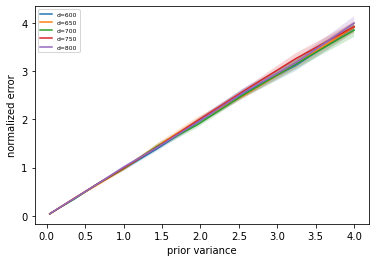

In [9]:





df = pd.read_csv ('../plots/all-last-10-50-800-50-1-667-0-0.0-2.0-0.0-2.0-5.0-1.2.csv')

plot_last_iter(df,'prior_sd' ,'TS-Bayes_errors','prior variance','normalized error','d','../plots/my_save_test1.pdf' )

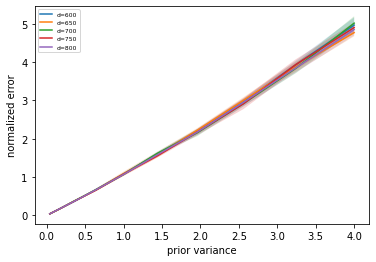

In [10]:
df = pd.read_csv ('../plots/all-last-10-50-800-50-1-667-0-0.0-2.0-5.0-2.0-5.0-1.2.csv')

plot_last_iter(df,'prior_sd' ,'TS-Bayes_errors','prior variance','normalized error','d','../plots/my_save_test2.pdf' )

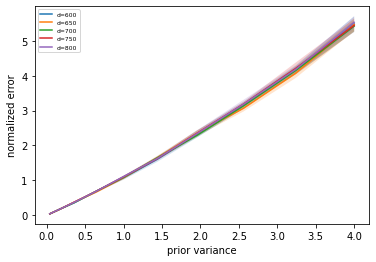

In [11]:
df = pd.read_csv ('../plots/all-last-10-50-800-50-1-1000-0-0.0-2.0-5.0-2.0-5.0-0.8.csv')

plot_last_iter(df,'prior_sd' ,'TS-Bayes_errors','prior variance','normalized error','d','../plots/my_save_test3.pdf' )

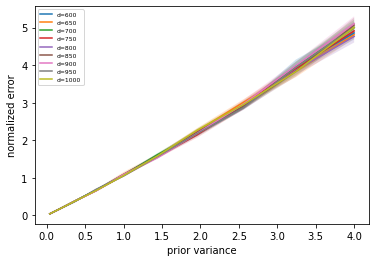

In [12]:
df = pd.read_csv ('../plots/all-last-10-50-1000-50-10-834-0-0.0-2.0-5.0-2.0-5.0-1.2.csv')

plot_last_iter(df,'prior_sd' ,'TS-Bayes_errors','prior variance','normalized error','d','../plots/my_save_test4.pdf' )

In [15]:
df = pd.read_csv ('../plots/all-10-50-1000-50-10-834-0-0.0-2.0-5.0-2.0-5.0-1.2.csv')

plot_sample_path(df,'prior_sd' ,'TS-Bayes_errors','prior variance','normalized error','d','../plots/my_save_test4.pdf' )

In [36]:
df1 = df.loc[df['prior_sd'] == 2.0]
df2 = df1.loc[df1['d'] == 800]

In [37]:
print(df2)

         d  prior_sd  TS-Bayes_regret_mean  TS-Bayes_regret_se  \
56053  800       2.0              0.185204            0.027884   
56054  800       2.0              0.168807            0.051438   
56055  800       2.0              0.171835            0.042081   
56056  800       2.0              0.164040            0.041249   
56057  800       2.0              0.156416            0.026072   
...    ...       ...                   ...                 ...   
56715  800       2.0              0.165844            0.027372   
56716  800       2.0              0.211658            0.034495   
56717  800       2.0              0.204278            0.037830   
56718  800       2.0              0.126788            0.052677   
56719  800       2.0              0.207391            0.046380   

       TS-Bayes_thinnesses_mean  TS-Bayes_thinnesses_se  TS-Bayes_errors_mean  \
56053                  1.000008            1.101746e-07              3.850000   
56054                  1.000017            1.

37960    0.040642
37961    0.040643
37962    0.040642
37963    0.040643
37964    0.040646
           ...   
38539    0.040649
38540    0.040649
38541    0.040650
38542    0.040650
38543    0.040649
Name: TS-Bayes_errors_mean, Length: 584, dtype: float64
43800    0.040174
43801    0.040175
43802    0.040177
43803    0.040171
43804    0.040174
           ...   
44420    0.040244
44421    0.040244
44422    0.040244
44423    0.040244
44424    0.040244
Name: TS-Bayes_errors_mean, Length: 625, dtype: float64
50050    0.040014
50051    0.040015
50052    0.040014
50053    0.040014
50054    0.040011
           ...   
50712    0.040129
50713    0.040128
50714    0.040128
50715    0.040130
50716    0.040131
Name: TS-Bayes_errors_mean, Length: 667, dtype: float64
56720    0.040414
56721    0.040415
56722    0.040416
56723    0.040416
56724    0.040417
           ...   
57424    0.040569
57425    0.040572
57426    0.040573
57427    0.040574
57428    0.040573
Name: TS-Bayes_errors_mean, Length: 709,

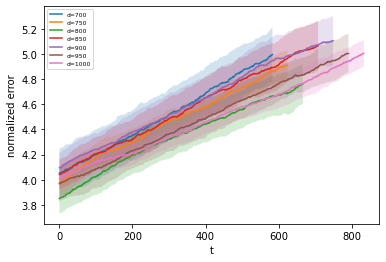

In [30]:
if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
from plotting import *

df = pd.read_csv ('../plots/all-10-50-1000-50-10-834-0-0.0-2.0-5.0-2.0-5.0-1.2.csv')

plot_sample_path(df,'prior_sd' ,'TS-Bayes_errors','t','normalized error','prior_sd','d','../plots/', 'my_save_test5.pdf' )

56910    0.039166
56911    0.039168
56912    0.039168
56913    0.039168
56914    0.039170
           ...   
57780    0.039383
57781    0.039385
57782    0.039386
57783    0.039391
57784    0.039394
Name: TS-Bayes_errors_mean, Length: 875, dtype: float64
65660    0.039723
65661    0.039722
65662    0.039721
65663    0.039718
65664    0.039717
           ...   
66593    0.039858
66594    0.039856
66595    0.039856
66596    0.039853
66597    0.039852
Name: TS-Bayes_errors_mean, Length: 938, dtype: float64
75040    0.040699
75041    0.040700
75042    0.040702
75043    0.040700
75044    0.040703
           ...   
76035    0.040832
76036    0.040833
76037    0.040834
76038    0.040833
76039    0.040834
Name: TS-Bayes_errors_mean, Length: 1000, dtype: float64
57785    0.160536
57786    0.160574
57787    0.160578
57788    0.160551
57789    0.160560
           ...   
58655    0.162660
58656    0.162673
58657    0.162666
58658    0.162653
58659    0.162642
Name: TS-Bayes_errors_mean, Length: 875

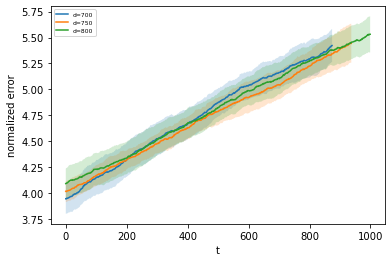

In [38]:
if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
from plotting import *

df = pd.read_csv ('../plots/all-10-50-800-50-1-1000-0-0.0-2.0-5.0-2.0-5.0-0.8.csv')

plot_sample_path(df,'prior_sd' ,'TS-Bayes_errors','t','normalized error','prior_sd','d','../plots/', 'my_save_test6.pdf' )


37960    0.039165
37961    0.039165
37962    0.039165
37963    0.039165
37964    0.039165
           ...   
38539    0.039157
38540    0.039157
38541    0.039157
38542    0.039157
38543    0.039157
Name: TS-Bayes_errors_mean, Length: 584, dtype: float64
43800    0.039723
43801    0.039723
43802    0.039723
43803    0.039723
43804    0.039723
           ...   
44420    0.039714
44421    0.039714
44422    0.039714
44423    0.039714
44424    0.039714
Name: TS-Bayes_errors_mean, Length: 625, dtype: float64
50050    0.040700
50051    0.040700
50052    0.040700
50053    0.040700
50054    0.040699
           ...   
50712    0.040690
50713    0.040690
50714    0.040690
50715    0.040690
50716    0.040690
Name: TS-Bayes_errors_mean, Length: 667, dtype: float64
38544    0.160534
38545    0.160534
38546    0.160533
38547    0.160533
38548    0.160533
           ...   
39123    0.160392
39124    0.160392
39125    0.160391
39126    0.160391
39127    0.160391
Name: TS-Bayes_errors_mean, Length: 584,

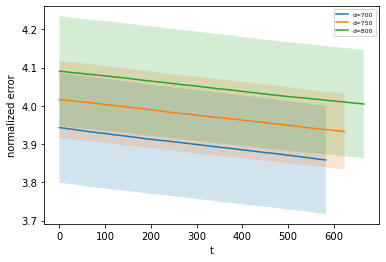

In [39]:
if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
from plotting import *

df = pd.read_csv ('../plots/all-10-50-800-50-1-667-0-0.0-2.0-0.0-2.0-5.0-1.2.csv')

plot_sample_path(df,'prior_sd' ,'TS-Bayes_errors','t','normalized error','prior_sd','d','../plots/', 'my_save_test7.pdf' )




17520    0.040612
17521    0.040614
17522    0.040615
17523    0.040610
17524    0.040612
           ...   
18015    0.040789
18016    0.040787
18017    0.040784
18018    0.040784
18019    0.040794
Name: TS-Bayes_errors_mean, Length: 500, dtype: float64
22520    0.040967
22521    0.040968
22522    0.040966
22523    0.040966
22524    0.040966
           ...   
23078    0.041178
23079    0.041181
23080    0.041179
23081    0.041178
23082    0.041178
Name: TS-Bayes_errors_mean, Length: 563, dtype: float64
28150    0.040030
28151    0.040027
28152    0.040030
28153    0.040032
28154    0.040035
           ...   
28770    0.040250
28771    0.040249
28772    0.040249
28773    0.040251
28774    0.040246
Name: TS-Bayes_errors_mean, Length: 625, dtype: float64
18020    0.165072
18021    0.165078
18022    0.165083
18023    0.165062
18024    0.165167
           ...   
18515    0.168101
18516    0.168128
18517    0.168099
18518    0.168125
18519    0.168134
Name: TS-Bayes_errors_mean, Length: 500,

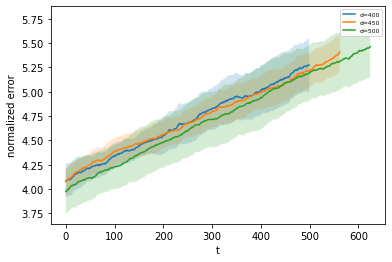

In [41]:

if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
from plotting import *

df = pd.read_csv ('../plots/all-10-50-500-50-10-625-0-0.0-2.0-5.0-2.0-5.0-0.8.csv')

plot_sample_path(df,'prior_sd' ,'TS-Bayes_errors','t','normalized error','prior_sd','d','../plots/', 'my_save_test8.pdf' )





11690    0.040616
11691    0.040621
11692    0.040622
11693    0.040626
11694    0.040625
           ...   
12019    0.040648
12020    0.040648
12021    0.040652
12022    0.040657
12023    0.040660
Name: TS-Bayes_errors_mean, Length: 334, dtype: float64
15030    0.040969
15031    0.040974
15032    0.040968
15033    0.040970
15034    0.040966
           ...   
15400    0.041036
15401    0.041036
15402    0.041030
15403    0.041027
15404    0.041027
Name: TS-Bayes_errors_mean, Length: 375, dtype: float64
18780    0.040036
18781    0.040036
18782    0.040036
18783    0.040036
18784    0.040042
           ...   
19192    0.040227
19193    0.040230
19194    0.040229
19195    0.040233
19196    0.040234
Name: TS-Bayes_errors_mean, Length: 417, dtype: float64
22950    0.039823
22951    0.039825
22952    0.039820
22953    0.039821
22954    0.039823
           ...   
23404    0.039968
23405    0.039968
23406    0.039965
23407    0.039967
23408    0.039966
Name: TS-Bayes_errors_mean, Length: 459,

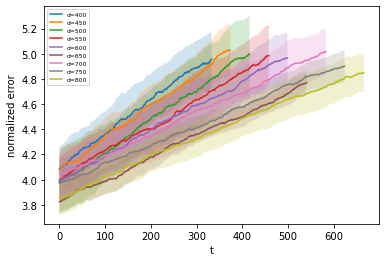

In [45]:

if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
from plotting import *

df = pd.read_csv ('../plots/all-10-50-800-50-1-667-0-0.0-2.0-5.0-2.0-5.0-1.2.csv')

plot_sample_path(df,'prior_sd' ,'TS-Bayes_errors','t','normalized error','prior_sd','d','../plots/', 'my_save_test10.pdf' )




In [ ]:

if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
from plotting import *

df = pd.read_csv ('../plots/all-10-50-800-50-1-667-0-0.0-2.0-5.0-2.0-5.0-1.2.csv')

plot_sample_path(df,'prior_sd' ,'TS-Bayes_errors','t','normalized error','prior_sd','d','../plots/', 'my_save_test10.pdf' )



all-last-10-50-800-50-1-667-0-0.0-2.0-0.0-2.0-5.0-1.2

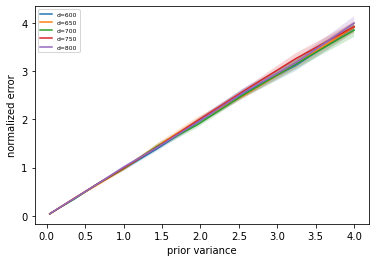

In [50]:

df = pd.read_csv ('../plots/all-last-10-50-800-50-1-667-0-0.0-2.0-5.0-2.0-5.0-1.2.csv')

plot_last_iter(df,'prior_sd' ,'TS-Bayes_errors','prior variance','normalized error','d','../plots/my_save_test9-2.pdf' )

###
plt.clf()
###

df = pd.read_csv ('../plots/all-last-10-50-800-50-1-667-0-0.0-2.0-0.0-2.0-5.0-1.2.csv')

plot_last_iter(df,'prior_sd' ,'TS-Bayes_errors','prior variance','normalized error','d','../plots/my_save_test10-2.pdf' )




[ 50 100]
0     0.042173
1     0.042173
2     0.042172
3     0.042172
4     0.042174
        ...   
58    0.042182
59    0.042181
60    0.042180
61    0.042181
62    0.042181
Name: TS-ThinnessDirected_errors_mean, Length: 63, dtype: float64
378    0.040044
379    0.040044
380    0.040044
381    0.040044
382    0.040043
         ...   
498    0.040038
499    0.040037
500    0.040038
501    0.040037
502    0.040037
Name: TS-ThinnessDirected_errors_mean, Length: 125, dtype: float64
63     0.360011
64     0.359987
65     0.359948
66     0.359913
67     0.359932
         ...   
121    0.359269
122    0.359302
123    0.359317
124    0.359329
125    0.359382
Name: TS-ThinnessDirected_errors_mean, Length: 63, dtype: float64
503    0.362446
504    0.362445
505    0.362444
506    0.362443
507    0.362441
         ...   
623    0.361431
624    0.361418
625    0.361402
626    0.361383
627    0.361375
Name: TS-ThinnessDirected_errors_mean, Length: 125, dtype: float64
126    0.936235
127    0.936064

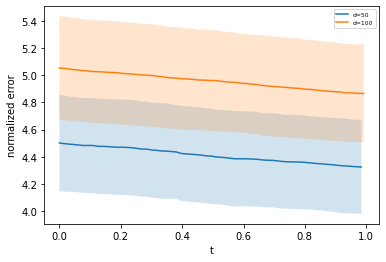

In [62]:
if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
from plotting import *
df = pd.read_csv ('../plots/all-last-10-50-100-50-1-125-3-0.0-2.2-0.2-2.0-5.0-0.8.csv')

plot_last_iter(df,'prior_sd' ,'TS-ThinnessDirected_errors','prior variance','normalized error','d','../plots/my_save_test12-1.pdf' )
# TS-Bayes_errors, TS-Freq_errors, TS-Improved_errors, TS-Thinness_errors, TS-ThinnessDirected_errors
# 
df = pd.read_csv ('../plots/all-10-50-100-50-1-125-3-0.0-2.2-0.2-2.0-5.0-0.8.csv')

plot_sample_path(df,'prior_sd' ,'TS-ThinnessDirected_errors','t','normalized error','prior_sd','d','../plots/', 'my_save_test12-2.pdf',1 )

[ 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800]
0     0.041326
1     0.041326
2     0.041326
3     0.041326
4     0.041326
5     0.041325
6     0.041325
7     0.041325
8     0.041325
9     0.041324
10    0.041324
11    0.041324
12    0.041324
13    0.041323
14    0.041323
15    0.041323
16    0.041323
17    0.041323
18    0.041323
19    0.041322
20    0.041322
21    0.041322
22    0.041321
23    0.041321
24    0.041320
25    0.041320
26    0.041320
27    0.041320
28    0.041320
29    0.041319
30    0.041319
31    0.041319
32    0.041319
33    0.041318
34    0.041318
35    0.041318
36    0.041318
37    0.041318
38    0.041318
39    0.041318
40    0.041317
41    0.041317
Name: TS-Bayes_errors_mean, dtype: float64
420    0.039683
421    0.039683
422    0.039683
423    0.039683
424    0.039683
         ...   
499    0.039675
500    0.039675
501    0.039675
502    0.039675
503    0.039675
Name: TS-Bayes_errors_mean, Length: 84, dtype: float64
1260    0.037773
1261    0.037

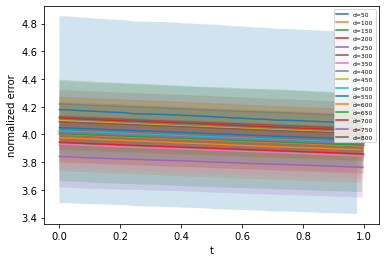

In [66]:
if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
from plotting import *
df = pd.read_csv ('../plots/all-last-10-50-800-50-1-667-0-0.0-2.0-0.0-2.0-5.0-1.2.csv')

plot_last_iter(df,'prior_sd' ,'TS-Bayes_errors','prior variance','normalized error','d','../plots/my_save_test13-1.pdf' )
# TS-Bayes_errors, TS-Freq_errors, TS-Improved_errors, TS-Thinness_errors, TS-ThinnessDirected_errors
# 
df = pd.read_csv ('../plots/all-10-50-800-50-1-667-0-0.0-2.0-0.0-2.0-5.0-1.2.csv')

plot_sample_path(df,'prior_sd' ,'TS-Bayes_errors','t','normalized error','prior_sd','d','../plots/', 'my_save_test13-2.pdf',1 )

[ 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800]
0     0.041330
1     0.041329
2     0.041319
3     0.041330
4     0.041329
        ...   
58    0.041734
59    0.041748
60    0.041753
61    0.041758
62    0.041805
Name: TS-Bayes_errors_mean, Length: 63, dtype: float64
630    0.039682
631    0.039692
632    0.039673
633    0.039677
634    0.039692
         ...   
750    0.040035
751    0.040018
752    0.040004
753    0.040008
754    0.039990
Name: TS-Bayes_errors_mean, Length: 125, dtype: float64
1880    0.037767
1881    0.037770
1882    0.037777
1883    0.037789
1884    0.037821
          ...   
2063    0.038193
2064    0.038205
2065    0.038204
2066    0.038206
2067    0.038197
Name: TS-Bayes_errors_mean, Length: 188, dtype: float64
3760    0.038118
3761    0.038115
3762    0.038128
3763    0.038119
3764    0.038112
          ...   
4005    0.038251
4006    0.038249
4007    0.038254
4008    0.038263
4009    0.038260
Name: TS-Bayes_errors_mean, Length: 250, dtype: floa

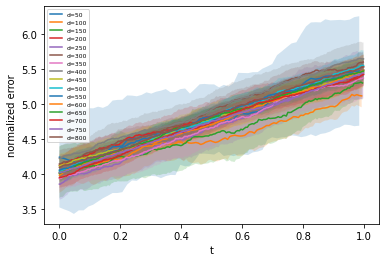

In [67]:
if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
from plotting import *
df = pd.read_csv ('../plots/all-last-10-50-800-50-1-1000-0-0.0-2.0-5.0-2.0-5.0-0.8.csv')

plot_last_iter(df,'prior_sd' ,'TS-Bayes_errors','prior variance','normalized error','d','../plots/my_save_test14-1.pdf' )
# TS-Bayes_errors, TS-Freq_errors, TS-Improved_errors, TS-Thinness_errors, TS-ThinnessDirected_errors
# 
df = pd.read_csv ('../plots/all-10-50-800-50-1-1000-0-0.0-2.0-5.0-2.0-5.0-0.8.csv')

plot_sample_path(df,'prior_sd' ,'TS-Bayes_errors','t','normalized error','prior_sd','d','../plots/', 'my_save_test14-2.pdf',1 )




[ 50 100 150 200 250 300 350 400]
0     0.041326
1     0.041326
2     0.041326
3     0.041326
4     0.041326
        ...   
58    0.041313
59    0.041313
60    0.041313
61    0.041312
62    0.041312
Name: TS-Bayes_errors_mean, Length: 63, dtype: float64
630    0.039683
631    0.039683
632    0.039683
633    0.039683
634    0.039683
         ...   
750    0.039671
751    0.039671
752    0.039671
753    0.039671
754    0.039671
Name: TS-Bayes_errors_mean, Length: 125, dtype: float64
1880    0.037773
1881    0.037773
1882    0.037772
1883    0.037772
1884    0.037772
          ...   
2063    0.037760
2064    0.037760
2065    0.037760
2066    0.037760
2067    0.037760
Name: TS-Bayes_errors_mean, Length: 188, dtype: float64
3760    0.038122
3761    0.038121
3762    0.038121
3763    0.038121
3764    0.038121
          ...   
4005    0.038109
4006    0.038109
4007    0.038109
4008    0.038109
4009    0.038109
Name: TS-Bayes_errors_mean, Length: 250, dtype: float64
6260    0.039815
6261    0.0

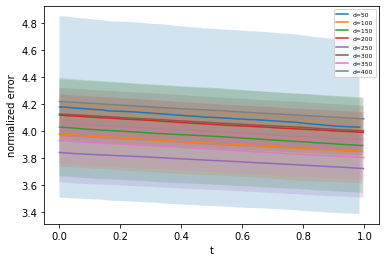

In [71]:
if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
from plotting import *

name = '10-50-400-50-1-500-0-0.0-2.0-0.0-2.0-5.0-0.8'

df = pd.read_csv ('../plots/all-last-'+name+'.csv')

plot_last_iter(df,'prior_sd' ,'TS-Bayes_errors','prior variance','normalized error','d','../plots/'+name+'-1.pdf' )
# TS-Bayes_errors, TS-Freq_errors, TS-Improved_errors, TS-Thinness_errors, TS-ThinnessDirected_errors
# 
df = pd.read_csv ('../plots/all-'+name+'.csv')

plot_sample_path(df,'prior_sd' ,'TS-Bayes_errors','t','normalized error','prior_sd','d','../plots/', name+'-2.pdf',1 )






[ 50 100 150 200 250 300]
0     103.281551
1     102.858130
2     101.767262
3     101.129842
4     100.864357
         ...    
58     79.859620
59     79.968183
60     79.720088
61     79.082543
62     79.546706
Name: TS-Bayes_errors_mean, Length: 63, dtype: float64
315    98.351414
316    97.973156
317    97.690341
318    97.147454
319    96.910834
         ...    
435    73.173475
436    73.117878
437    72.632054
438    72.210294
439    71.925273
Name: TS-Bayes_errors_mean, Length: 125, dtype: float64
940     97.945267
941     97.762948
942     97.721922
943     97.607238
944     97.312538
          ...    
1123    72.271977
1124    72.126963
1125    72.182834
1126    72.119968
1127    71.990826
Name: TS-Bayes_errors_mean, Length: 188, dtype: float64
1880    102.861956
1881    102.884087
1882    102.581873
1883    102.466580
1884    102.419191
           ...    
2125     75.744124
2126     75.709618
2127     75.559109
2128     75.606107
2129     75.772808
Name: TS-Bayes_errors_mean

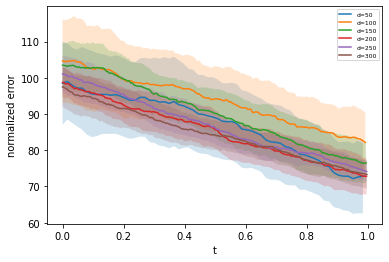

In [77]:
if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
from plotting import *

name = '10-50-300-50-100-375-0-0.0-10.0-1.0-2.0-5.0-0.8' 

df = pd.read_csv ('../plots/all-last-'+name+'.csv')

plot_last_iter(df,'k' ,'TS-Bayes_errors','k','normalized error','d','../plots/figures/'+name+'-1.jpg' )
# TS-Bayes_errors, TS-Freq_errors, TS-Improved_errors, TS-Thinness_errors, TS-ThinnessDirected_errors
# 
df = pd.read_csv ('../plots/all-'+name+'.csv')

plot_sample_path(df,'k' ,'TS-Bayes_errors','t','normalized error','k','d','../plots/figures/', name+'-2.jpg',1 )








[ 50 100 150 200 250 300 350 400]
0     4.120528
1     4.117066
2     4.112103
3     4.110664
4     4.115485
        ...   
58    4.030918
59    4.031364
60    4.033866
61    4.032393
62    4.015062
Name: TS-Bayes_errors_mean, Length: 63, dtype: float64
315    3.951835
316    3.951281
317    3.951700
318    3.951991
319    3.952128
         ...   
435    3.923783
436    3.924719
437    3.923540
438    3.925750
439    3.926747
Name: TS-Bayes_errors_mean, Length: 125, dtype: float64
940     3.921656
941     3.921140
942     3.921255
943     3.918953
944     3.917045
          ...   
1123    3.879493
1124    3.879181
1125    3.878798
1126    3.876901
1127    3.875377
Name: TS-Bayes_errors_mean, Length: 188, dtype: float64
1880    4.117011
1881    4.116173
1882    4.115275
1883    4.111285
1884    4.110867
          ...   
2125    4.007341
2126    4.007054
2127    4.007193
2128    4.005561
2129    4.006226
Name: TS-Bayes_errors_mean, Length: 250, dtype: float64
3130    3.823868
3131    3.8

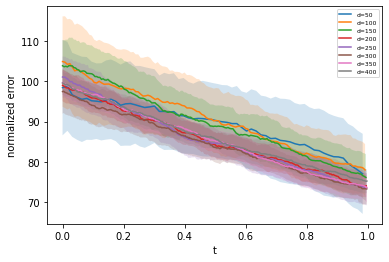

In [80]:
if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
from plotting import *

name = '10-50-400-50-10-500-0-0.0-10-1.0-2.0-5.0-0.8'

df = pd.read_csv ('../plots/all-last-'+name+'.csv')

plot_last_iter(df,'prior_sd' ,'TS-Bayes_errors','prior variance','normalized error','d','../plots/figures/'+name+'-1.jpg' )
# TS-Bayes_errors, TS-Freq_errors, TS-Improved_errors, TS-Thinness_errors, TS-ThinnessDirected_errors
# 
df = pd.read_csv ('../plots/all-'+name+'.csv')

plot_sample_path(df,'prior_sd' ,'TS-Bayes_errors','t','normalized error','prior_sd','d','../plots/figures/', name+'-2.jpg',1 )






[ 50 100 150 200]
0     0.042173
1     0.042170
2     0.042172
3     0.042171
4     0.042171
        ...   
58    0.042163
59    0.042161
60    0.042159
61    0.042159
62    0.042158
Name: TS-ThinnessDirected_errors_mean, Length: 63, dtype: float64
378    0.040044
379    0.040043
380    0.040043
381    0.040043
382    0.040042
         ...   
498    0.040033
499    0.040032
500    0.040032
501    0.040031
502    0.040030
Name: TS-ThinnessDirected_errors_mean, Length: 125, dtype: float64
1128    0.043029
1129    0.043029
1130    0.043029
1131    0.043029
1132    0.043028
          ...   
1311    0.043021
1312    0.043020
1313    0.043020
1314    0.043020
1315    0.043021
Name: TS-ThinnessDirected_errors_mean, Length: 188, dtype: float64
2256    0.039563
2257    0.039564
2258    0.039563
2259    0.039563
2260    0.039563
          ...   
2501    0.039550
2502    0.039550
2503    0.039549
2504    0.039549
2505    0.039549
Name: TS-ThinnessDirected_errors_mean, Length: 250, dtype: float64


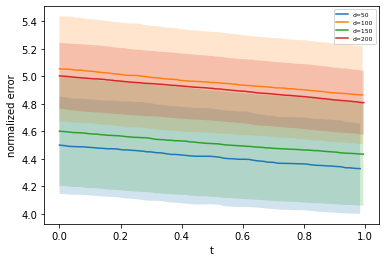

In [84]:
if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
from plotting import *

name = '10-50-200-50-10-250-3-0.0-2.2-0.2-2.0-5.0-0.8'

df = pd.read_csv ('../plots/all-last-'+name+'.csv')

plot_last_iter(df,'prior_sd' ,'TS-ThinnessDirected_errors','prior variance','normalized error','d','../plots/ThinnessDirected/'+name+'-1.jpg' )
# TS-Bayes_errors, TS-Freq_errors, TS-Improved_errors, TS-Thinness_errors, TS-ThinnessDirected_errors
# 
df = pd.read_csv ('../plots/all-'+name+'.csv')

plot_sample_path(df,'prior_sd' ,'TS-ThinnessDirected_errors','t','normalized error','prior_sd','d','../plots/ThinnessDirected/', name+'-2.jpg',1 )









In [ ]:
if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
from plotting import *

name = '10-50-200-50-10-250-3-0.0-2.2-0.2-2.0-5.0-0.8'

df = pd.read_csv ('../plots/all-last-'+name+'.csv')

plot_last_iter(df,'prior_sd' ,'TS-ThinnessDirected_errors','prior variance','normalized error','d','../plots/ThinnessDirected/'+name+'-1.jpg' )
# TS-Bayes_errors, TS-Freq_errors, TS-Improved_errors, TS-Thinness_errors, TS-ThinnessDirected_errors
# 
df = pd.read_csv ('../plots/all-'+name+'.csv')

plot_sample_path(df,'prior_sd' ,'TS-ThinnessDirected_errors','t','normalized error','prior_sd','d','../plots/ThinnessDirected/', name+'-2.jpg',1 )









[ 50 100 150 200]
0     104.798250
1     104.447311
2     103.478480
3     102.799392
4     102.963842
         ...    
58     83.252586
59     82.564632
60     82.400760
61     81.844609
62     81.594434
Name: TS-ThinnessDirected_errors_mean, Length: 63, dtype: float64
315    98.745427
316    98.877428
317    98.932717
318    98.667715
319    98.744917
         ...    
435    73.848595
436    73.504307
437    73.787803
438    73.295305
439    73.109487
Name: TS-ThinnessDirected_errors_mean, Length: 125, dtype: float64
940     99.078205
941     99.138682
942     98.953216
943     98.949917
944     98.867599
          ...    
1123    75.621442
1124    75.474652
1125    75.491467
1126    75.546240
1127    75.218972
Name: TS-ThinnessDirected_errors_mean, Length: 188, dtype: float64
1880    97.400544
1881    97.153806
1882    96.972647
1883    96.810964
1884    96.855834
          ...    
2125    72.530161
2126    72.485083
2127    72.402887
2128    72.585553
2129    72.459669
Name: TS-Thi

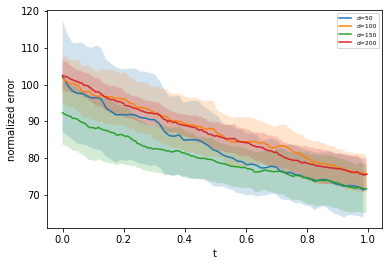

In [15]:
if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
from plotting import *

name = '10-50-200-50-100-250-3-0.0-10.0-1.0-2.0-5.0-0.8'
method = 'TS-ThinnessDirected_errors'
save_path = '../plots2/'+method+'/'

df = pd.read_csv ('../plots/all-last-'+name+'.csv')

isExist = os.path.exists(save_path)

if not isExist:
    os.makedirs(save_path)



plot_last_iter(df,'k' ,method,'k','normalized error','d',save_path+name+'-1.jpg' )
# TS-Bayes_errors, TS-Freq_errors, TS-Improved_errors, TS-Thinness_errors, TS-ThinnessDirected_errors
# 
df = pd.read_csv ('../plots/all-'+name+'.csv')

plot_sample_path(df,'k' ,method,'t','normalized error','k','d',save_path, name+'-2.jpg',1 )






[ 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800]
0     103.281551
1     102.858130
2     101.767262
3     101.129842
4     100.864357
         ...    
58     79.859620
59     79.968183
60     79.720088
61     79.082543
62     79.546706
Name: TS-Bayes_errors_mean, Length: 63, dtype: float64
315    98.351414
316    97.973156
317    97.690341
318    97.147454
319    96.910834
         ...    
435    73.173475
436    73.117878
437    72.632054
438    72.210294
439    71.925273
Name: TS-Bayes_errors_mean, Length: 125, dtype: float64
940     97.945267
941     97.762948
942     97.721922
943     97.607238
944     97.312538
          ...    
1123    72.271977
1124    72.126963
1125    72.182834
1126    72.119968
1127    71.990826
Name: TS-Bayes_errors_mean, Length: 188, dtype: float64
1880    102.861956
1881    102.884087
1882    102.581873
1883    102.466580
1884    102.419191
           ...    
2125     75.744124
2126     75.709618
2127     75.559109
2128     75.606107
2129 

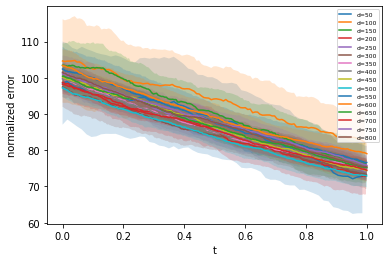

In [16]:
if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
from plotting import *

name = '10-50-800-50-100-1000-0-0.0-10.0-1.0-2.0-5.0-0.8'
method = 'TS-Bayes_errors'
save_path = '../plots3/'+method+'/'

df = pd.read_csv ('../plots/all-last-'+name+'.csv')

isExist = os.path.exists(save_path)

if not isExist:
    os.makedirs(save_path)



plot_last_iter(df,'k' ,method,'k','normalized error','d',save_path+name+'-1.jpg' )
# TS-Bayes_errors, TS-Freq_errors, TS-Improved_errors, TS-Thinness_errors, TS-ThinnessDirected_errors
# 
df = pd.read_csv ('../plots/all-'+name+'.csv')

plot_sample_path(df,'k' ,method,'t','normalized error','k','d',save_path, name+'-2.jpg',1 )






[ 50 100 150 200]
0     0.253194
1     0.253758
2     0.254336
3     0.254714
4     0.255092
        ...   
58    0.263417
59    0.263468
60    0.263546
61    0.263650
62    0.263740
Name: TS-Bayes_lambda_maxs_mean, Length: 63, dtype: float64
315    0.253374
316    0.253735
317    0.254037
318    0.254273
319    0.254400
         ...   
435    0.264060
436    0.264147
437    0.264176
438    0.264222
439    0.264313
Name: TS-Bayes_lambda_maxs_mean, Length: 125, dtype: float64
940     0.253223
941     0.253675
942     0.253813
943     0.253987
944     0.254247
          ...   
1123    0.264159
1124    0.264233
1125    0.264304
1126    0.264345
1127    0.264374
Name: TS-Bayes_lambda_maxs_mean, Length: 188, dtype: float64
1880    0.253383
1881    0.253763
1882    0.253961
1883    0.254045
1884    0.254202
          ...   
2125    0.264677
2126    0.264703
2127    0.264731
2128    0.264787
2129    0.264800
Name: TS-Bayes_lambda_maxs_mean, Length: 250, dtype: float64
63     0.066057
64     0

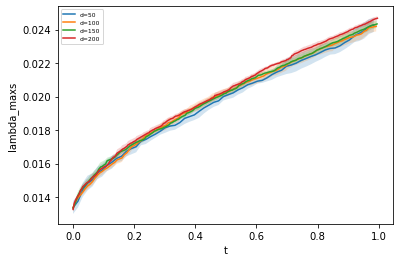

In [2]:
if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
from plotting import *

name = '10-50-200-50-1-250-0-0.0-10-1.0-2.0-5.0-0.8'
method = 'TS-Bayes_lambda_maxs'
save_path = '../plots4/'+method+'/'

df = pd.read_csv ('../plots/all-last-'+name+'.csv')

isExist = os.path.exists(save_path)

if not isExist:
    os.makedirs(save_path)



plot_last_iter(df,'prior_sd' ,method,'prior_sd','lambda_maxs','d',save_path+name+'-1.jpg' )
# TS-Bayes_errors, TS-Freq_errors, TS-Improved_errors, TS-Thinness_errors, TS-ThinnessDirected_errors
# 
df = pd.read_csv ('../plots/all-'+name+'.csv')

plot_sample_path(df,'prior_sd' ,method,'t','lambda_maxs','prior_sd','d',save_path, name+'-2.jpg',1 )





[ 50 100 150 200]
0     0.250000
1     0.250000
2     0.250000
3     0.250000
4     0.250000
        ...   
58    0.250042
59    0.250058
60    0.250069
61    0.250078
62    0.250090
Name: TS-Bayes_lambda_mins_mean, Length: 63, dtype: float64
315    0.250000
316    0.250000
317    0.250000
318    0.250000
319    0.250000
         ...   
435    0.250043
436    0.250046
437    0.250052
438    0.250055
439    0.250059
Name: TS-Bayes_lambda_mins_mean, Length: 125, dtype: float64
940     0.250000
941     0.250000
942     0.250000
943     0.250000
944     0.250000
          ...   
1123    0.250047
1124    0.250051
1125    0.250053
1126    0.250057
1127    0.250058
Name: TS-Bayes_lambda_mins_mean, Length: 188, dtype: float64
1880    0.250000
1881    0.250000
1882    0.250000
1883    0.250000
1884    0.250000
          ...   
2125    0.250049
2126    0.250050
2127    0.250053
2128    0.250054
2129    0.250055
Name: TS-Bayes_lambda_mins_mean, Length: 250, dtype: float64
63     0.062500
64     0

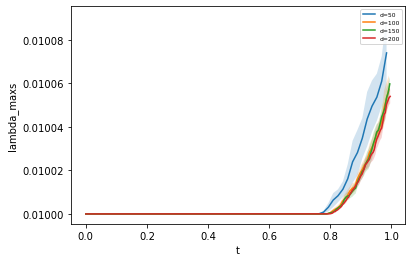

In [3]:
if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
from plotting import *

name = '10-50-200-50-1-250-0-0.0-10-1.0-2.0-5.0-0.8'
method = 'TS-Bayes_lambda_mins'
save_path = '../plots4/'+method+'/'

df = pd.read_csv ('../plots/all-last-'+name+'.csv')

isExist = os.path.exists(save_path)

if not isExist:
    os.makedirs(save_path)



plot_last_iter(df,'prior_sd' ,method,'prior_sd','lambda_maxs','d',save_path+name+'-1.jpg' )
# TS-Bayes_errors, TS-Freq_errors, TS-Improved_errors, TS-Thinness_errors, TS-ThinnessDirected_errors
# 
df = pd.read_csv ('../plots/all-'+name+'.csv')

plot_sample_path(df,'prior_sd' ,method,'t','lambda_maxs','prior_sd','d',save_path, name+'-2.jpg',1 )





In [4]:
np.arange(300,350,50)

array([300])

[ 50 100 150 200]
0     0.013194
1     0.013758
2     0.014336
3     0.014714
4     0.015092
        ...   
58    0.023417
59    0.023468
60    0.023546
61    0.023650
62    0.023740
Name: TS-Bayes_lambda_maxs_mean, Length: 63, dtype: float64
315    0.013374
316    0.013735
317    0.014037
318    0.014273
319    0.014400
         ...   
435    0.024060
436    0.024147
437    0.024176
438    0.024222
439    0.024313
Name: TS-Bayes_lambda_maxs_mean, Length: 125, dtype: float64
940     0.013223
941     0.013675
942     0.013813
943     0.013987
944     0.014247
          ...   
1123    0.024159
1124    0.024233
1125    0.024304
1126    0.024345
1127    0.024374
Name: TS-Bayes_lambda_maxs_mean, Length: 188, dtype: float64
1880    0.013383
1881    0.013763
1882    0.013961
1883    0.014045
1884    0.014202
          ...   
2125    0.024677
2126    0.024703
2127    0.024731
2128    0.024787
2129    0.024800
Name: TS-Bayes_lambda_maxs_mean, Length: 250, dtype: float64
63     0.013485
64     0

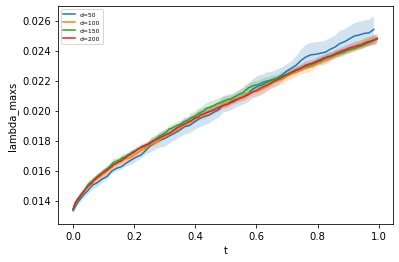

In [7]:
if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
from plotting import * 

name = '10-50-200-50-100-250-0-0.0-10.0-1.0-2.0-5.0-0.8'
method = 'TS-Bayes_lambda_maxs'
save_path = '../plots5/'+method+'/'

df = pd.read_csv ('../plots/all-last-'+name+'.csv')

isExist = os.path.exists(save_path)

if not isExist:
    os.makedirs(save_path)



plot_last_iter(df,'k' ,method,'k','lambda_maxs','d',save_path+name+'-1.jpg' )
# TS-Bayes_errors, TS-Freq_errors, TS-Improved_errors, TS-Thinness_errors, TS-ThinnessDirected_errors
# 
df = pd.read_csv ('../plots/all-'+name+'.csv')

plot_sample_path(df,'k' ,method,'t','lambda_maxs','k','d',save_path, name+'-2.jpg',1 )





[ 50 100 150 200]
0     1.017035e+06
1     1.005558e+06
2     9.867327e+05
3     9.605770e+05
4     9.530380e+05
          ...     
58    1.574614e+03
59    1.300696e+03
60    1.255104e+03
61    1.172383e+03
62    1.136492e+03
Name: TS-Bayes_errors_mean, Length: 63, dtype: float64
315    970811.046859
316    958455.569265
317    944683.845063
318    936203.297611
319    929592.669358
           ...      
435      1561.506043
436      1528.052370
437      1457.484456
438      1443.945676
439      1437.295747
Name: TS-Bayes_errors_mean, Length: 125, dtype: float64
940     976269.879230
941     969577.267160
942     964499.167884
943     961522.369465
944     955581.220544
            ...      
1123      1261.610967
1124      1229.559657
1125      1203.728779
1126      1194.243412
1127      1182.557634
Name: TS-Bayes_errors_mean, Length: 188, dtype: float64
1880    1.024791e+06
1881    1.022989e+06
1882    1.018875e+06
1883    1.010450e+06
1884    1.005149e+06
            ...     
2125   

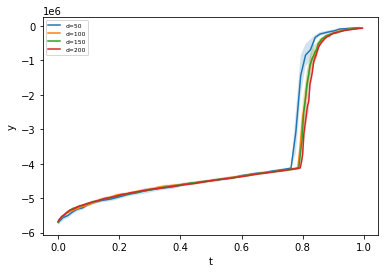

In [16]:

name = '10-50-200-50-100-250-0-0.0-1000.0-1.0-2.0-5.0-0.8'

if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
    
from plotting import * 
method_list = ['TS-Bayes_errors','TS-Bayes_lambda_mins', 'TS-Bayes_lambda_maxs','TS-Bayes_log_maxs_over_mins']



for method in method_list:
    save_path = '../plots6/'+method+'/'
    isExist = os.path.exists(save_path)
    if not isExist:
        os.makedirs(save_path)

    df = pd.read_csv ('../plots/all-last-'+name+'.csv')
    plot_last_iter(df,'k' ,method,'k','y','d',save_path+name+'-1.jpg' )
    # TS-Bayes_errors, TS-Freq_errors, TS-Improved_errors, TS-Thinness_errors, TS-ThinnessDirected_errors

    df = pd.read_csv ('../plots/all-'+name+'.csv')
    plot_sample_path(df,'k' ,method,'t','y','k','d',save_path, name+'-2.jpg',1 )





[ 50 100 150 200]
0     4.132662
1     4.131357
2     4.127248
3     4.126580
4     4.125555
        ...   
58    4.113551
59    4.115550
60    4.115712
61    4.114489
62    4.122222
Name: TS-Bayes_errors_mean, Length: 63, dtype: float64
315    3.950423
316    3.949709
317    3.949688
318    3.943999
319    3.943550
         ...   
435    3.850930
436    3.850039
437    3.849605
438    3.843954
439    3.841185
Name: TS-Bayes_errors_mean, Length: 125, dtype: float64
940     3.923541
941     3.922980
942     3.924473
943     3.923035
944     3.921401
          ...   
1123    3.837771
1124    3.836387
1125    3.837397
1126    3.836064
1127    3.836014
Name: TS-Bayes_errors_mean, Length: 188, dtype: float64
1880    4.117460
1881    4.117876
1882    4.114717
1883    4.115286
1884    4.115595
          ...   
2125    4.050179
2126    4.049912
2127    4.048782
2128    4.049307
2129    4.051840
Name: TS-Bayes_errors_mean, Length: 250, dtype: float64
63     4.071369
64     4.075242
65     4.070

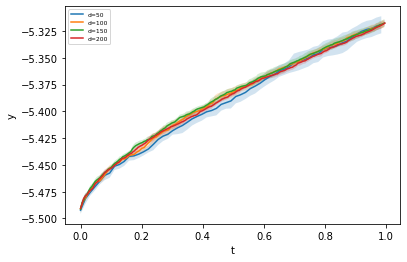

In [15]:

name = '10-50-200-50-100-250-0-0.0-2.0-1.0-2.0-5.0-0.8'

if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
    
from plotting import * 
method_list = ['TS-Bayes_errors','TS-Bayes_lambda_mins', 'TS-Bayes_lambda_maxs','TS-Bayes_log_maxs_over_mins']



for method in method_list:
    save_path = '../plots7/'+method+'/'
    isExist = os.path.exists(save_path)
    if not isExist:
        os.makedirs(save_path)

    df = pd.read_csv ('../plots/all-last-'+name+'.csv')
    plot_last_iter(df,'k' ,method,'k','y','d',save_path+name+'-1.jpg' )
    # TS-Bayes_errors, TS-Freq_errors, TS-Improved_errors, TS-Thinness_errors, TS-ThinnessDirected_errors

    df = pd.read_csv ('../plots/all-'+name+'.csv')
    plot_sample_path(df,'k' ,method,'t','y','k','d',save_path, name+'-2.jpg',1 )






[ 50 100 150 200]
0     1.017035e+06
1     1.005558e+06
2     9.867327e+05
3     9.605770e+05
4     9.530380e+05
          ...     
79    4.628872e+02
80    4.557562e+02
81    4.320660e+02
82    4.161489e+02
83    3.983113e+02
Name: TS-Bayes_errors_mean, Length: 84, dtype: float64
420    970811.046859
421    958455.569265
422    944683.845063
423    936203.297611
424    929592.669358
           ...      
582       493.093929
583       488.730111
584       476.284185
585       473.429232
586       459.830060
Name: TS-Bayes_errors_mean, Length: 167, dtype: float64
1255    976269.879230
1256    969577.267160
1257    964499.167884
1258    961522.369465
1259    955581.220544
            ...      
1500       456.673094
1501       457.804385
1502       452.284786
1503       448.342352
1504       439.538738
Name: TS-Bayes_errors_mean, Length: 250, dtype: float64
2505    1.024791e+06
2506    1.022989e+06
2507    1.018875e+06
2508    1.010450e+06
2509    1.005149e+06
            ...     
2834   

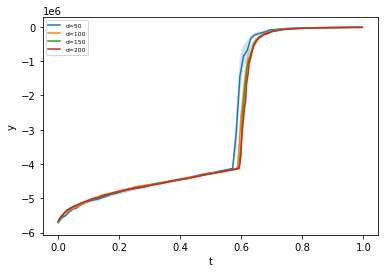

In [18]:

name = '10-50-200-50-100-334-0-0.0-1000.0-1.0-2.0-5.0-0.6'

if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
    
from plotting import * 
method_list = ['TS-Bayes_errors','TS-Bayes_lambda_mins', 'TS-Bayes_lambda_maxs','TS-Bayes_log_maxs_over_mins']



for method in method_list:
    save_path = '../plots8/'+method+'/'
    isExist = os.path.exists(save_path)
    if not isExist:
        os.makedirs(save_path)

    df = pd.read_csv ('../plots/all-last-'+name+'.csv')
    plot_last_iter(df,'k' ,method,'k','y','d',save_path+name+'-1.jpg' )
    # TS-Bayes_errors, TS-Freq_errors, TS-Improved_errors, TS-Thinness_errors, TS-ThinnessDirected_errors

    df = pd.read_csv ('../plots/all-'+name+'.csv')
    plot_sample_path(df,'k' ,method,'t','y','k','d',save_path, name+'-2.jpg',1 )





[ 50 100 150 200]
0     4.132662
1     4.131357
2     4.127248
3     4.126580
4     4.125555
        ...   
79    4.136401
80    4.134936
81    4.131028
82    4.133370
83    4.129046
Name: TS-Bayes_errors_mean, Length: 84, dtype: float64
420    3.950423
421    3.949709
422    3.949688
423    3.943999
424    3.943550
         ...   
582    3.815388
583    3.816462
584    3.814791
585    3.813734
586    3.816659
Name: TS-Bayes_errors_mean, Length: 167, dtype: float64
1255    3.923541
1256    3.922980
1257    3.924473
1258    3.923035
1259    3.921401
          ...   
1500    3.841801
1501    3.840693
1502    3.839053
1503    3.840898
1504    3.839336
Name: TS-Bayes_errors_mean, Length: 250, dtype: float64
2505    4.117460
2506    4.117876
2507    4.114717
2508    4.115286
2509    4.115595
          ...   
2834    4.021705
2835    4.020829
2836    4.018317
2837    4.018219
2838    4.017870
Name: TS-Bayes_errors_mean, Length: 334, dtype: float64
84     4.071369
85     4.075242
86     4.070

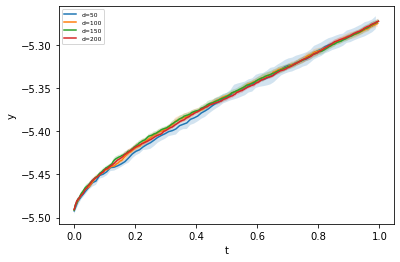

In [19]:

name = '10-50-200-50-100-334-0-0.0-2.0-1.0-2.0-5.0-0.6'

if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
    
from plotting import * 
method_list = ['TS-Bayes_errors','TS-Bayes_lambda_mins', 'TS-Bayes_lambda_maxs','TS-Bayes_log_maxs_over_mins']



for method in method_list:
    save_path = '../plots9/'+method+'/'
    isExist = os.path.exists(save_path)
    if not isExist:
        os.makedirs(save_path)

    df = pd.read_csv ('../plots/all-last-'+name+'.csv')
    plot_last_iter(df,'k' ,method,'k','y','d',save_path+name+'-1.jpg' )
    # TS-Bayes_errors, TS-Freq_errors, TS-Improved_errors, TS-Thinness_errors, TS-ThinnessDirected_errors

    df = pd.read_csv ('../plots/all-'+name+'.csv')
    plot_sample_path(df,'k' ,method,'t','y','k','d',save_path, name+'-2.jpg',1 )





[ 50 100 150 200]
0      1.017035e+06
1      1.005558e+06
2      9.867327e+05
3      9.605770e+05
4      9.530380e+05
           ...     
495    3.447522e+01
496    3.435110e+01
497    3.432718e+01
498    3.454106e+01
499    3.439187e+01
Name: TS-Bayes_errors_mean, Length: 500, dtype: float64
2500    970811.046859
2501    958455.569265
2502    944683.845063
2503    936203.297611
2504    929592.669358
            ...      
3495        34.309489
3496        34.248884
3497        34.241861
3498        34.302056
3499        34.218127
Name: TS-Bayes_errors_mean, Length: 1000, dtype: float64
7500    976269.879230
7501    969577.267160
7502    964499.167884
7503    961522.369465
7504    955581.220544
            ...      
8995        34.092393
8996        34.203093
8997        34.158143
8998        34.086500
8999        34.086339
Name: TS-Bayes_errors_mean, Length: 1500, dtype: float64
15000    1.024791e+06
15001    1.022989e+06
15002    1.018875e+06
15003    1.010450e+06
15004    1.005149e+0

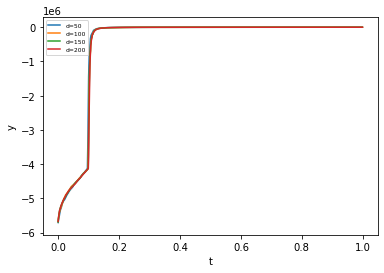

In [20]:



name = '10-50-200-50-100-2000-0-0.0-1000.0-1.0-2.0-5.0-0.1'

if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
    
from plotting import * 
method_list = ['TS-Bayes_errors','TS-Bayes_lambda_mins', 'TS-Bayes_lambda_maxs','TS-Bayes_log_maxs_over_mins']



for method in method_list:
    save_path = '../plots10/'+method+'/'
    isExist = os.path.exists(save_path)
    if not isExist:
        os.makedirs(save_path)

    df = pd.read_csv ('../plots/all-last-'+name+'.csv')
    plot_last_iter(df,'k' ,method,'k','y','d',save_path+name+'-1.jpg' )
    # TS-Bayes_errors, TS-Freq_errors, TS-Improved_errors, TS-Thinness_errors, TS-ThinnessDirected_errors

    df = pd.read_csv ('../plots/all-'+name+'.csv')
    plot_sample_path(df,'k' ,method,'t','y','k','d',save_path, name+'-2.jpg',1 )





[ 3  6  9 12 15 18 21 24 27 30]
0       754718.923378
1       474624.924369
2         1040.148826
3          482.074510
4          369.893681
            ...      
2995         0.309769
2996         0.308244
2997         0.312921
2998         0.310195
2999         0.309952
Name: TS-Bayes_errors_mean, Length: 3000, dtype: float64
15000    720560.550535
15001    563878.788752
15002    419401.522214
15003    340864.620497
15004    126161.218382
             ...      
20995         0.313878
20996         0.315198
20997         0.314296
20998         0.314825
20999         0.314460
Name: TS-Bayes_errors_mean, Length: 6000, dtype: float64
45000    875294.689945
45001    740548.911800
45002    710045.007776
45003    624382.991182
45004    528216.194918
             ...      
53995         0.254475
53996         0.255707
53997         0.255543
53998         0.255288
53999         0.256051
Name: TS-Bayes_errors_mean, Length: 9000, dtype: float64
90000     892238.647430
90001     807837.492921
9

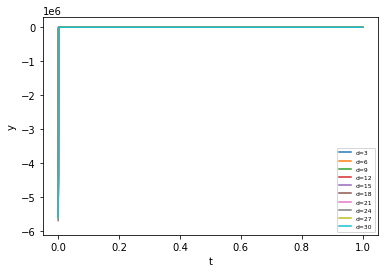

In [21]:
name = '10-3-30-3-100-30000-0-0.0-1000.0-1.0-2.0-5.0-0.001'

if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
    
from plotting import * 
method_list = ['TS-Bayes_errors','TS-Bayes_lambda_mins', 'TS-Bayes_lambda_maxs','TS-Bayes_log_maxs_over_mins']



for method in method_list:
    save_path = '../plots11/'+method+'/'
    isExist = os.path.exists(save_path)
    if not isExist:
        os.makedirs(save_path)

    df = pd.read_csv ('../plots/all-last-'+name+'.csv')
    plot_last_iter(df,'k' ,method,'k','y','d',save_path+name+'-1.jpg' )
    # TS-Bayes_errors, TS-Freq_errors, TS-Improved_errors, TS-Thinness_errors, TS-ThinnessDirected_errors

    df = pd.read_csv ('../plots/all-'+name+'.csv')
    plot_sample_path(df,'k' ,method,'t','y','k','d',save_path, name+'-2.jpg',1 )





[  1   3  10  50 100]
0       754718.923378
1       474624.924369
2         1040.148826
3          482.074510
4          369.893681
            ...      
2995         0.309769
2996         0.308244
2997         0.312921
2998         0.310195
2999         0.309952
Name: TS-Bayes_errors_mean, Length: 3000, dtype: float64
3000    343420.525103
3001    163540.755906
3002      6071.706199
3003      1685.012020
3004       977.786416
            ...      
5995         0.289099
5996         0.289747
5997         0.288261
5998         0.282099
5999         0.280767
Name: TS-Bayes_errors_mean, Length: 3000, dtype: float64
6000    739625.324270
6001    337716.744830
6002     46973.787504
6003       630.645979
6004       767.971919
            ...      
8995         0.426401
8996         0.431817
8997         0.436363
8998         0.435669
8999         0.429597
Name: TS-Bayes_errors_mean, Length: 3000, dtype: float64
9000     1.000425e+06
9001     3.167341e+05
9002     1.100849e+03
9003     5.8683

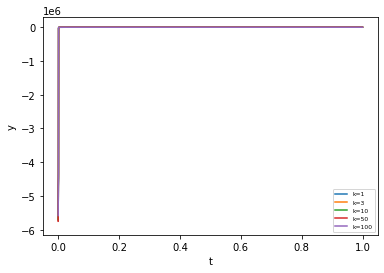

In [22]:
name = '10-3-30-3-100-30000-0-0.0-1000.0-1.0-2.0-5.0-0.001'

if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
    
from plotting import * 
method_list = ['TS-Bayes_errors','TS-Bayes_lambda_mins', 'TS-Bayes_lambda_maxs','TS-Bayes_log_maxs_over_mins']



for method in method_list:
    save_path = '../plots12/'+method+'/'
    isExist = os.path.exists(save_path)
    if not isExist:
        os.makedirs(save_path)

    df = pd.read_csv ('../plots/all-last-'+name+'.csv')
    plot_last_iter(df,'d' ,method,'d','y','k',save_path+name+'-1.jpg' )
    # TS-Bayes_errors, TS-Freq_errors, TS-Improved_errors, TS-Thinness_errors, TS-ThinnessDirected_errors

    df = pd.read_csv ('../plots/all-'+name+'.csv')
    plot_sample_path(df,'d' ,method,'t','y','d','k',save_path, name+'-2.jpg',1 )





[  1   3  10  50 100]
0      1.017035e+06
1      1.005558e+06
2      9.867327e+05
3      9.605770e+05
4      9.530380e+05
           ...     
495    3.447522e+01
496    3.435110e+01
497    3.432718e+01
498    3.454106e+01
499    3.439187e+01
Name: TS-Bayes_errors_mean, Length: 500, dtype: float64
500    998338.288430
501    965126.466950
502    949296.038068
503    922563.437987
504    906042.298178
           ...      
995        32.994093
996        32.935320
997        33.036672
998        33.058244
999        32.947645
Name: TS-Bayes_errors_mean, Length: 500, dtype: float64
1000    870394.980557
1001    859350.023636
1002    846762.380075
1003    817204.043368
1004    796307.928315
            ...      
1495        37.390198
1496        37.204045
1497        37.589924
1498        37.484284
1499        37.475878
Name: TS-Bayes_errors_mean, Length: 500, dtype: float64
1500    1.045959e+06
1501    1.036257e+06
1502    1.017851e+06
1503    1.003466e+06
1504    9.835138e+05
            

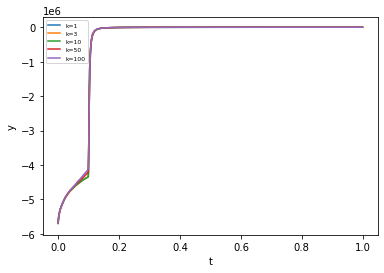

In [23]:
name = '10-50-200-50-100-2000-0-0.0-1000.0-1.0-2.0-5.0-0.1'

if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
    
from plotting import * 
method_list = ['TS-Bayes_errors','TS-Bayes_lambda_mins', 'TS-Bayes_lambda_maxs','TS-Bayes_log_maxs_over_mins']



for method in method_list:
    save_path = '../plots13/'+method+'/'
    isExist = os.path.exists(save_path)
    if not isExist:
        os.makedirs(save_path)

    df = pd.read_csv ('../plots/all-last-'+name+'.csv')
    plot_last_iter(df,'d' ,method,'d','y','k',save_path+name+'-1.jpg' )
    # TS-Bayes_errors, TS-Freq_errors, TS-Improved_errors, TS-Thinness_errors, TS-ThinnessDirected_errors

    df = pd.read_csv ('../plots/all-'+name+'.csv')
    plot_sample_path(df,'d' ,method,'t','y','d','k',save_path, name+'-2.jpg',1 )





[  1   3  10  50 100]
0     4.132662
1     4.131357
2     4.127248
3     4.126580
4     4.125555
        ...   
79    4.136401
80    4.134936
81    4.131028
82    4.133370
83    4.129046
Name: TS-Bayes_errors_mean, Length: 84, dtype: float64
84     4.071369
85     4.075242
86     4.070874
87     4.070508
88     4.067330
         ...   
163    3.949145
164    3.941939
165    3.937912
166    3.938667
167    3.926793
Name: TS-Bayes_errors_mean, Length: 84, dtype: float64
168    3.592952
169    3.600874
170    3.604466
171    3.605979
172    3.606936
         ...   
247    3.521954
248    3.513646
249    3.514940
250    3.518318
251    3.512197
Name: TS-Bayes_errors_mean, Length: 84, dtype: float64
252    4.270556
253    4.269683
254    4.263041
255    4.257490
256    4.240935
         ...   
331    4.167439
332    4.161415
333    4.156124
334    4.152803
335    4.153739
Name: TS-Bayes_errors_mean, Length: 84, dtype: float64
336    3.942943
337    3.939090
338    3.929770
339    3.930508
3

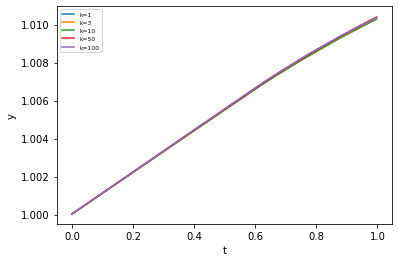

In [25]:
name = '10-50-200-50-100-334-0-0.0-2.0-1.0-2.0-5.0-0.6'

if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
    
from plotting import * 
method_list = ['TS-Bayes_errors','TS-Bayes_lambda_mins', 'TS-Bayes_lambda_maxs','TS-Bayes_log_maxs_over_mins', 'TS-Bayes_thinnesses']



for method in method_list:
    save_path = '../plots14/'+method+'/'
    isExist = os.path.exists(save_path)
    if not isExist:
        os.makedirs(save_path)

    df = pd.read_csv ('../plots/all-last-'+name+'.csv')
    plot_last_iter(df,'d' ,method,'d','y','k',save_path+name+'-1.jpg' )
    # TS-Bayes_errors, TS-Freq_errors, TS-Improved_errors, TS-Thinness_errors, TS-ThinnessDirected_errors

    df = pd.read_csv ('../plots/all-'+name+'.csv')
    plot_sample_path(df,'d' ,method,'t','y','d','k',save_path, name+'-2.jpg',1 )





[ 50 100 150 200]
0     4.132662
1     4.131357
2     4.127248
3     4.126580
4     4.125555
        ...   
79    4.136401
80    4.134936
81    4.131028
82    4.133370
83    4.129046
Name: TS-Bayes_errors_mean, Length: 84, dtype: float64
420    3.950423
421    3.949709
422    3.949688
423    3.943999
424    3.943550
         ...   
582    3.815388
583    3.816462
584    3.814791
585    3.813734
586    3.816659
Name: TS-Bayes_errors_mean, Length: 167, dtype: float64
1255    3.923541
1256    3.922980
1257    3.924473
1258    3.923035
1259    3.921401
          ...   
1500    3.841801
1501    3.840693
1502    3.839053
1503    3.840898
1504    3.839336
Name: TS-Bayes_errors_mean, Length: 250, dtype: float64
2505    4.117460
2506    4.117876
2507    4.114717
2508    4.115286
2509    4.115595
          ...   
2834    4.021705
2835    4.020829
2836    4.018317
2837    4.018219
2838    4.017870
Name: TS-Bayes_errors_mean, Length: 334, dtype: float64
84     4.071369
85     4.075242
86     4.070

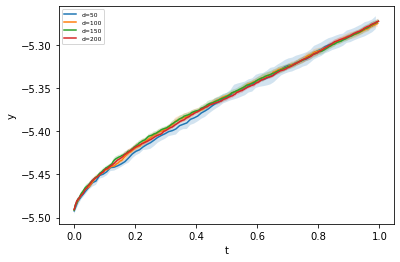

In [26]:



name = '10-50-200-50-100-334-0-0.0-2.0-1.0-2.0-5.0-0.6'

if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
    
from plotting import * 
method_list = ['TS-Bayes_errors','TS-Bayes_lambda_mins', 'TS-Bayes_lambda_maxs','TS-Bayes_log_maxs_over_mins']



for method in method_list:
    save_path = '../plots15/'+method+'/'
    isExist = os.path.exists(save_path)
    if not isExist:
        os.makedirs(save_path)

    df = pd.read_csv ('../plots/all-last-'+name+'.csv')
    plot_last_iter(df,'k' ,method,'k','y','d',save_path+name+'-1.jpg' )
    # TS-Bayes_errors, TS-Freq_errors, TS-Improved_errors, TS-Thinness_errors, TS-ThinnessDirected_errors

    df = pd.read_csv ('../plots/all-'+name+'.csv')
    plot_sample_path(df,'k' ,method,'t','y','k','d',save_path, name+'-2.jpg',1 )





[ 50 100 150 200]
0      4.132662
1      4.131357
2      4.127248
3      4.126580
4      4.125555
         ...   
495    3.689853
496    3.685252
497    3.687351
498    3.692132
499    3.686974
Name: TS-Bayes_errors_mean, Length: 500, dtype: float64
2500    3.950423
2501    3.949709
2502    3.949688
2503    3.943999
2504    3.943550
          ...   
3495    3.558473
3496    3.560249
3497    3.561497
3498    3.561037
3499    3.559345
Name: TS-Bayes_errors_mean, Length: 1000, dtype: float64
7500    3.923541
7501    3.922980
7502    3.924473
7503    3.923035
7504    3.921401
          ...   
8995    3.537965
8996    3.539970
8997    3.540118
8998    3.538977
8999    3.539549
Name: TS-Bayes_errors_mean, Length: 1500, dtype: float64
15000    4.117460
15001    4.117876
15002    4.114717
15003    4.115286
15004    4.115595
           ...   
16995    3.642150
16996    3.643291
16997    3.642435
16998    3.642605
16999    3.642347
Name: TS-Bayes_errors_mean, Length: 2000, dtype: float64
500    

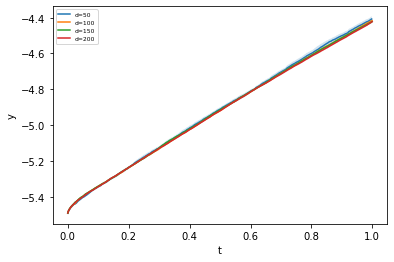

In [27]:

name = '10-50-200-50-100-2000-0-0.0-2.0-1.0-2.0-5.0-0.1'

if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
    
from plotting import * 
method_list = ['TS-Bayes_errors','TS-Bayes_lambda_mins', 'TS-Bayes_lambda_maxs','TS-Bayes_log_maxs_over_mins', 'TS-Bayes_thinnesses']



for method in method_list:
    save_path = '../plots16/'+method+'/'
    isExist = os.path.exists(save_path)
    if not isExist:
        os.makedirs(save_path)

    df = pd.read_csv ('../plots/all-last-'+name+'.csv')
    plot_last_iter(df,'k' ,method,'k','y','d',save_path+name+'-1.jpg' )
    # TS-Bayes_errors, TS-Freq_errors, TS-Improved_errors, TS-Thinness_errors, TS-ThinnessDirected_errors

    df = pd.read_csv ('../plots/all-'+name+'.csv')
    plot_sample_path(df,'k' ,method,'t','y','k','d',save_path, name+'-2.jpg',1 )





[  1   3  10  50 100]
0      4.132662
1      4.131357
2      4.127248
3      4.126580
4      4.125555
         ...   
495    3.689853
496    3.685252
497    3.687351
498    3.692132
499    3.686974
Name: TS-Bayes_errors_mean, Length: 500, dtype: float64
500    4.071369
501    4.075242
502    4.070874
503    4.070508
504    4.067330
         ...   
995    3.556953
996    3.549457
997    3.548671
998    3.537544
999    3.534247
Name: TS-Bayes_errors_mean, Length: 500, dtype: float64
1000    3.592952
1001    3.600874
1002    3.604466
1003    3.605979
1004    3.606936
          ...   
1495    3.315855
1496    3.314611
1497    3.305633
1498    3.299635
1499    3.279436
Name: TS-Bayes_errors_mean, Length: 500, dtype: float64
1500    4.270556
1501    4.269683
1502    4.263041
1503    4.257490
1504    4.240935
          ...   
1995    3.700413
1996    3.698696
1997    3.683852
1998    3.680132
1999    3.680107
Name: TS-Bayes_errors_mean, Length: 500, dtype: float64
2000    3.942943
2001    3.9

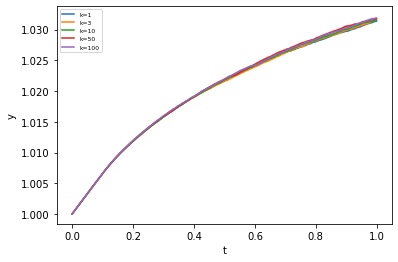

In [31]:

name = '10-50-200-50-100-2000-0-0.0-2.0-1.0-2.0-5.0-0.1'



if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
    
from plotting import * 
method_list = ['TS-Bayes_errors','TS-Bayes_lambda_mins', 'TS-Bayes_lambda_maxs','TS-Bayes_log_maxs_over_mins', 'TS-Bayes_thinnesses']



for method in method_list:
    save_path = '../plots17/'+method+'/'
    isExist = os.path.exists(save_path)
    if not isExist:
        os.makedirs(save_path)

    df = pd.read_csv ('../plots/all-last-'+name+'.csv')
    plot_last_iter(df,'d' ,method,'d','y','k',save_path+name+'-1.jpg' )
    # TS-Bayes_errors, TS-Freq_errors, TS-Improved_errors, TS-Thinness_errors, TS-ThinnessDirected_errors

    df = pd.read_csv ('../plots/all-'+name+'.csv')
    plot_sample_path(df,'d' ,method,'t','y','d','k',save_path, name+'-2.jpg',1 )







[  1   3  10  50 100]
0       3.748169
1       3.742961
2       3.727703
3       3.626649
4       3.567073
          ...   
2995    0.303774
2996    0.302086
2997    0.305876
2998    0.303066
2999    0.302945
Name: TS-Bayes_errors_mean, Length: 3000, dtype: float64
3000    3.513516
3001    3.508916
3002    3.618309
3003    3.702207
3004    3.728194
          ...   
5995    0.229565
5996    0.226380
5997    0.226638
5998    0.224240
5999    0.224273
Name: TS-Bayes_errors_mean, Length: 3000, dtype: float64
6000    5.773318
6001    5.678504
6002    5.686167
6003    5.601767
6004    5.744019
          ...   
8995    0.419918
8996    0.419939
8997    0.424845
8998    0.425616
8999    0.424993
Name: TS-Bayes_errors_mean, Length: 3000, dtype: float64
9000     5.846753
9001     5.718946
9002     5.605166
9003     5.519532
9004     5.484314
           ...   
11995    0.202711
11996    0.202862
11997    0.203170
11998    0.204301
11999    0.204604
Name: TS-Bayes_errors_mean, Length: 3000, dtype:

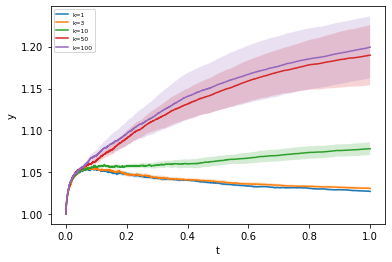

In [30]:

name = '10-3-30-3-100-30000-0-0.0-2.0-1.0-2.0-5.0-0.001'



if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
    
from plotting import * 
method_list = ['TS-Bayes_errors','TS-Bayes_lambda_mins', 'TS-Bayes_lambda_maxs','TS-Bayes_log_maxs_over_mins', 'TS-Bayes_thinnesses']



for method in method_list:
    save_path = '../plots18/'+method+'/'
    isExist = os.path.exists(save_path)
    if not isExist:
        os.makedirs(save_path)

    df = pd.read_csv ('../plots/all-last-'+name+'.csv')
    plot_last_iter(df,'d' ,method,'d','y','k',save_path+name+'-1.jpg' )
    # TS-Bayes_errors, TS-Freq_errors, TS-Improved_errors, TS-Thinness_errors, TS-ThinnessDirected_errors

    df = pd.read_csv ('../plots/all-'+name+'.csv')
    plot_sample_path(df,'d' ,method,'t','y','d','k',save_path, name+'-2.jpg',1 )







[  1   3  10  50 100]
0       4.132662
1       4.131357
2       4.127248
3       4.126580
4       4.125555
          ...   
4995    1.868551
4996    1.870692
4997    1.869560
4998    1.870128
4999    1.869506
Name: TS-Bayes_errors_mean, Length: 5000, dtype: float64
5000    4.071369
5001    4.075242
5002    4.070874
5003    4.070508
5004    4.067330
          ...   
9995    1.856400
9996    1.856348
9997    1.853065
9998    1.853275
9999    1.851661
Name: TS-Bayes_errors_mean, Length: 5000, dtype: float64
10000    3.592952
10001    3.600874
10002    3.604466
10003    3.605979
10004    3.606936
           ...   
14995    1.671916
14996    1.671901
14997    1.676013
14998    1.674927
14999    1.675974
Name: TS-Bayes_errors_mean, Length: 5000, dtype: float64
15000    4.270556
15001    4.269683
15002    4.263041
15003    4.257490
15004    4.240935
           ...   
19995    1.746471
19996    1.747565
19997    1.744224
19998    1.744198
19999    1.743674
Name: TS-Bayes_errors_mean, Length: 5

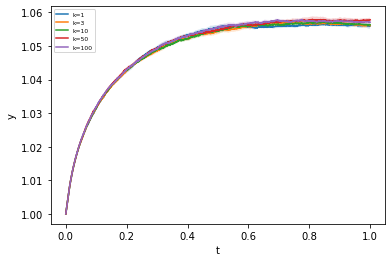

In [32]:

name = '10-50-200-50-100-20000-0-0.0-2.0-1.0-2.0-5.0-0.01'



if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
    
from plotting import * 
method_list = ['TS-Bayes_errors','TS-Bayes_lambda_mins', 'TS-Bayes_lambda_maxs','TS-Bayes_log_maxs_over_mins', 'TS-Bayes_thinnesses']



for method in method_list:
    save_path = '../plots19/'+method+'/'
    isExist = os.path.exists(save_path)
    if not isExist:
        os.makedirs(save_path)

    df = pd.read_csv ('../plots/all-last-'+name+'.csv')
    plot_last_iter(df,'d' ,method,'d','y','k',save_path+name+'-1.jpg' )
    # TS-Bayes_errors, TS-Freq_errors, TS-Improved_errors, TS-Thinness_errors, TS-ThinnessDirected_errors

    df = pd.read_csv ('../plots/all-'+name+'.csv')
    plot_sample_path(df,'d' ,method,'t','y','d','k',save_path, name+'-2.jpg',1 )







[  1   3  10  50 100]
0       1.017035e+06
1       1.005558e+06
2       9.867327e+05
3       9.605770e+05
4       9.530380e+05
            ...     
4995    3.245264e+00
4996    3.250903e+00
4997    3.252329e+00
4998    3.249061e+00
4999    3.246692e+00
Name: TS-Bayes_errors_mean, Length: 5000, dtype: float64
5000    998338.288430
5001    965126.466950
5002    949296.038068
5003    922563.437987
5004    906042.298178
            ...      
9995         2.962845
9996         2.973366
9997         2.972794
9998         2.973871
9999         2.972631
Name: TS-Bayes_errors_mean, Length: 5000, dtype: float64
10000    870394.980557
10001    859350.023636
10002    846762.380075
10003    817204.043368
10004    796307.928315
             ...      
14995         3.132499
14996         3.131015
14997         3.130505
14998         3.124535
14999         3.117944
Name: TS-Bayes_errors_mean, Length: 5000, dtype: float64
15000    1.045959e+06
15001    1.036257e+06
15002    1.017851e+06
15003    1.0034

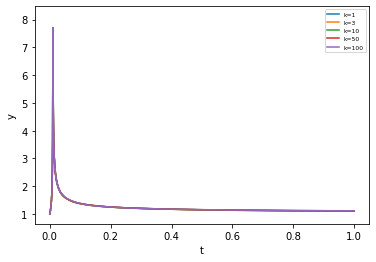

In [33]:
name = '10-50-200-50-100-20000-0-0.0-1000.0-1.0-2.0-5.0-0.01'

if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
    
from plotting import * 
method_list = ['TS-Bayes_errors','TS-Bayes_lambda_mins', 'TS-Bayes_lambda_maxs','TS-Bayes_log_maxs_over_mins', 'TS-Bayes_thinnesses']



for method in method_list:
    save_path = '../plots20/'+method+'/'
    isExist = os.path.exists(save_path)
    if not isExist:
        os.makedirs(save_path)

    df = pd.read_csv ('../plots/all-last-'+name+'.csv')
    plot_last_iter(df,'d' ,method,'d','y','k',save_path+name+'-1.jpg' )
    # TS-Bayes_errors, TS-Freq_errors, TS-Improved_errors, TS-Thinness_errors, TS-ThinnessDirected_errors

    df = pd.read_csv ('../plots/all-'+name+'.csv')
    plot_sample_path(df,'d' ,method,'t','y','d','k',save_path, name+'-2.jpg',1 )


[  1   3  10  50 100]
0       4.132662
1       4.131357
2       4.127248
3       4.126580
4       4.125555
          ...   
4995    1.868551
4996    1.870692
4997    1.869560
4998    1.870128
4999    1.869506
Name: TS-Bayes_errors_mean, Length: 5000, dtype: float64
5000    4.071369
5001    4.075242
5002    4.070874
5003    4.070508
5004    4.067330
          ...   
9995    1.856400
9996    1.856348
9997    1.853065
9998    1.853275
9999    1.851661
Name: TS-Bayes_errors_mean, Length: 5000, dtype: float64
10000    3.592952
10001    3.600874
10002    3.604466
10003    3.605979
10004    3.606936
           ...   
14995    1.671916
14996    1.671901
14997    1.676013
14998    1.674927
14999    1.675974
Name: TS-Bayes_errors_mean, Length: 5000, dtype: float64
15000    4.270556
15001    4.269683
15002    4.263041
15003    4.257490
15004    4.240935
           ...   
19995    1.746471
19996    1.747565
19997    1.744224
19998    1.744198
19999    1.743674
Name: TS-Bayes_errors_mean, Length: 5

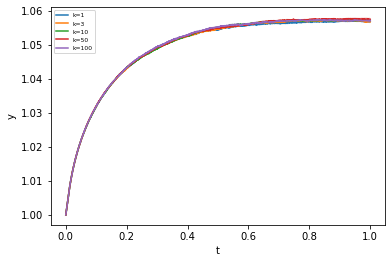

In [34]:
name = "10-50-500-50-100-50000-0-0.0-2.0-1.0-2.0-5.0-0.01"

if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
    
from plotting import * 
method_list = ['TS-Bayes_errors','TS-Bayes_lambda_mins', 'TS-Bayes_lambda_maxs','TS-Bayes_log_maxs_over_mins', 'TS-Bayes_thinnesses']



for method in method_list:
    save_path = '../plots21/'+method+'/'
    isExist = os.path.exists(save_path)
    if not isExist:
        os.makedirs(save_path)

    df = pd.read_csv ('../plots/all-last-'+name+'.csv')
    plot_last_iter(df,'d' ,method,'d','y','k',save_path+name+'-1.jpg' )
    # TS-Bayes_errors, TS-Freq_errors, TS-Improved_errors, TS-Thinness_errors, TS-ThinnessDirected_errors

    df = pd.read_csv ('../plots/all-'+name+'.csv')
    plot_sample_path(df,'d' ,method,'t','y','d','k',save_path, name+'-2.jpg',1 )

[  1   3  10  50 100]
0       1.017035e+06
1       1.005558e+06
2       9.867327e+05
3       9.605770e+05
4       9.530380e+05
            ...     
4995    3.245264e+00
4996    3.250903e+00
4997    3.252329e+00
4998    3.249061e+00
4999    3.246692e+00
Name: TS-Bayes_errors_mean, Length: 5000, dtype: float64
5000    998338.288430
5001    965126.466950
5002    949296.038068
5003    922563.437987
5004    906042.298178
            ...      
9995         2.962845
9996         2.973366
9997         2.972794
9998         2.973871
9999         2.972631
Name: TS-Bayes_errors_mean, Length: 5000, dtype: float64
10000    870394.980557
10001    859350.023636
10002    846762.380075
10003    817204.043368
10004    796307.928315
             ...      
14995         3.132499
14996         3.131015
14997         3.130505
14998         3.124535
14999         3.117944
Name: TS-Bayes_errors_mean, Length: 5000, dtype: float64
15000    1.045959e+06
15001    1.036257e+06
15002    1.017851e+06
15003    1.0034

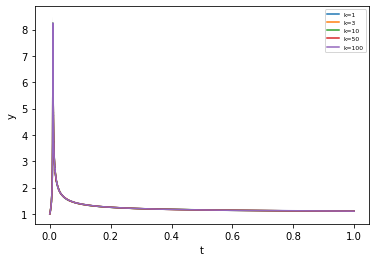

In [35]:


name = "10-50-500-50-100-50000-0-0.0-1000.0-1.0-2.0-5.0-0.01"

if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
    
from plotting import * 
method_list = ['TS-Bayes_errors','TS-Bayes_lambda_mins', 'TS-Bayes_lambda_maxs','TS-Bayes_log_maxs_over_mins', 'TS-Bayes_thinnesses']



for method in method_list:
    save_path = '../plots22/'+method+'/'
    isExist = os.path.exists(save_path)
    if not isExist:
        os.makedirs(save_path)

    df = pd.read_csv ('../plots/all-last-'+name+'.csv')
    plot_last_iter(df,'d' ,method,'d','y','k',save_path+name+'-1.jpg' )
    # TS-Bayes_errors, TS-Freq_errors, TS-Improved_errors, TS-Thinness_errors, TS-ThinnessDirected_errors

    df = pd.read_csv ('../plots/all-'+name+'.csv')
    plot_sample_path(df,'d' ,method,'t','y','d','k',save_path, name+'-2.jpg',1 )

[  1   3  10  50 100]
0       3.748169
1       3.742961
2       3.727703
3       3.626649
4       3.567073
          ...   
2995    0.303774
2996    0.302086
2997    0.305876
2998    0.303066
2999    0.302945
Name: TS-Bayes_errors_mean, Length: 3000, dtype: float64
3000    3.513516
3001    3.508916
3002    3.618309
3003    3.702207
3004    3.728194
          ...   
5995    0.229565
5996    0.226380
5997    0.226638
5998    0.224240
5999    0.224273
Name: TS-Bayes_errors_mean, Length: 3000, dtype: float64
6000    5.773318
6001    5.678504
6002    5.686167
6003    5.601767
6004    5.744019
          ...   
8995    0.419918
8996    0.419939
8997    0.424845
8998    0.425616
8999    0.424993
Name: TS-Bayes_errors_mean, Length: 3000, dtype: float64
9000     5.846753
9001     5.718946
9002     5.605166
9003     5.519532
9004     5.484314
           ...   
11995    0.202711
11996    0.202862
11997    0.203170
11998    0.204301
11999    0.204604
Name: TS-Bayes_errors_mean, Length: 3000, dtype:

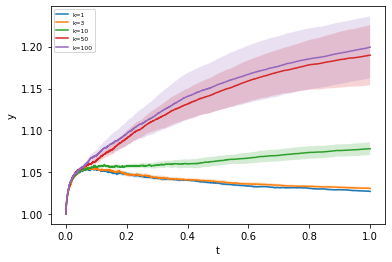

In [1]:


name = "10-3-30-3-100-30000-0-0.0-2.0-1.0-2.0-5.0-0.001"

if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
    
from plotting import * 
method_list = ['TS-Bayes_errors','TS-Bayes_lambda_mins', 'TS-Bayes_lambda_maxs','TS-Bayes_log_maxs_over_mins', 'TS-Bayes_thinnesses']



for method in method_list:
    save_path = '../plots22/'+method+'/'
    isExist = os.path.exists(save_path)
    if not isExist:
        os.makedirs(save_path)

    df = pd.read_csv ('../plots/all-last-'+name+'.csv')
    plot_last_iter(df,'d' ,method,'d','y','k',save_path+name+'-1.jpg' )
    # TS-Bayes_errors, TS-Freq_errors, TS-Improved_errors, TS-Thinness_errors, TS-ThinnessDirected_errors

    df = pd.read_csv ('../plots/all-'+name+'.csv')
    plot_sample_path(df,'d' ,method,'t','y','d','k',save_path, name+'-2.jpg',1 )

[  1   3  10  50 100]
0       754718.923378
1       474624.924369
2         1040.148826
3          482.074510
4          369.893681
            ...      
2995         0.309769
2996         0.308244
2997         0.312921
2998         0.310195
2999         0.309952
Name: TS-Bayes_errors_mean, Length: 3000, dtype: float64
3000    343420.525103
3001    163540.755906
3002      6071.706199
3003      1685.012020
3004       977.786416
            ...      
5995         0.289099
5996         0.289747
5997         0.288261
5998         0.282099
5999         0.280767
Name: TS-Bayes_errors_mean, Length: 3000, dtype: float64
6000    739625.324270
6001    337716.744830
6002     46973.787504
6003       630.645979
6004       767.971919
            ...      
8995         0.426401
8996         0.431817
8997         0.436363
8998         0.435669
8999         0.429597
Name: TS-Bayes_errors_mean, Length: 3000, dtype: float64
9000     1.000425e+06
9001     3.167341e+05
9002     1.100849e+03
9003     5.8683

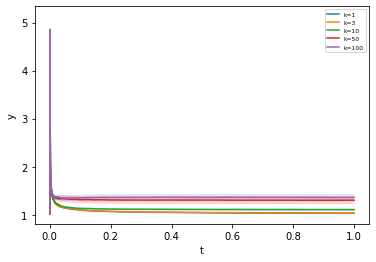

In [2]:


name = "10-3-30-3-100-30000-0-0.0-1000.0-1.0-2.0-5.0-0.001"

if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
    
from plotting import * 
method_list = ['TS-Bayes_errors','TS-Bayes_lambda_mins', 'TS-Bayes_lambda_maxs','TS-Bayes_log_maxs_over_mins', 'TS-Bayes_thinnesses']



for method in method_list:
    save_path = '../plots24/'+method+'/'
    isExist = os.path.exists(save_path)
    if not isExist:
        os.makedirs(save_path)

    df = pd.read_csv ('../plots/all-last-'+name+'.csv')
    plot_last_iter(df,'d' ,method,'d','y','k',save_path+name+'-1.jpg' )
    # TS-Bayes_errors, TS-Freq_errors, TS-Improved_errors, TS-Thinness_errors, TS-ThinnessDirected_errors

    df = pd.read_csv ('../plots/all-'+name+'.csv')
    plot_sample_path(df,'d' ,method,'t','y','d','k',save_path, name+'-2.jpg',1 )



[  1   3  10  50 100]
0       1.017035e+06
1       1.005558e+06
2       9.867327e+05
3       9.605770e+05
4       9.530380e+05
            ...     
4995    3.245264e+00
4996    3.250903e+00
4997    3.252329e+00
4998    3.249061e+00
4999    3.246692e+00
Name: TS-Bayes_errors_mean, Length: 5000, dtype: float64
5000    998338.288430
5001    965126.466950
5002    949296.038068
5003    922563.437987
5004    906042.298178
            ...      
9995         2.962845
9996         2.973366
9997         2.972794
9998         2.973871
9999         2.972631
Name: TS-Bayes_errors_mean, Length: 5000, dtype: float64
10000    870394.980557
10001    859350.023636
10002    846762.380075
10003    817204.043368
10004    796307.928315
             ...      
14995         3.132499
14996         3.131015
14997         3.130505
14998         3.124535
14999         3.117944
Name: TS-Bayes_errors_mean, Length: 5000, dtype: float64
15000    1.045959e+06
15001    1.036257e+06
15002    1.017851e+06
15003    1.0034

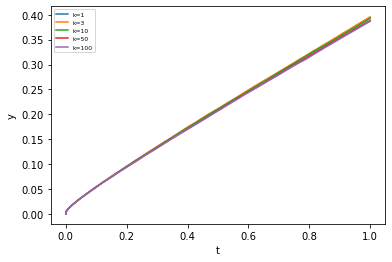

In [4]:


name = "10-50-100-50-100-10000-0-0.0-1000.0-1.0-2.0-5.0-0.01"

if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
    
from plotting import * 
method_list = ['TS-Bayes_errors','TS-Bayes_lambda_mins', 'TS-Bayes_lambda_maxs','TS-Bayes_log_maxs_over_mins', 'TS-Bayes_thinnesses',  'TS-Bayes_lambdas_second', 'TS-Bayes_lambdas_third']



for method in method_list:
    save_path = '../plots25/'+method+'/'
    isExist = os.path.exists(save_path)
    if not isExist:
        os.makedirs(save_path)

    df = pd.read_csv ('../plots/all-last-'+name+'.csv')
    plot_last_iter(df,'d' ,method,'d','y','k',save_path+name+'-1.jpg' )
    # TS-Bayes_errors, TS-Freq_errors, TS-Improved_errors, TS-Thinness_errors, TS-ThinnessDirected_errors

    df = pd.read_csv ('../plots/all-'+name+'.csv')
    plot_sample_path(df,'d' ,method,'t','y','d','k',save_path, name+'-2.jpg',1 )



[  1   3  10  50 100]
0       4.132662
1       4.131357
2       4.127248
3       4.126580
4       4.125555
          ...   
4995    1.868551
4996    1.870692
4997    1.869560
4998    1.870128
4999    1.869506
Name: TS-Bayes_errors_mean, Length: 5000, dtype: float64
5000    4.071369
5001    4.075242
5002    4.070874
5003    4.070508
5004    4.067330
          ...   
9995    1.856400
9996    1.856348
9997    1.853065
9998    1.853275
9999    1.851661
Name: TS-Bayes_errors_mean, Length: 5000, dtype: float64
10000    3.592952
10001    3.600874
10002    3.604466
10003    3.605979
10004    3.606936
           ...   
14995    1.671916
14996    1.671901
14997    1.676013
14998    1.674927
14999    1.675974
Name: TS-Bayes_errors_mean, Length: 5000, dtype: float64
15000    4.270556
15001    4.269683
15002    4.263041
15003    4.257490
15004    4.240935
           ...   
19995    1.746471
19996    1.747565
19997    1.744224
19998    1.744198
19999    1.743674
Name: TS-Bayes_errors_mean, Length: 5

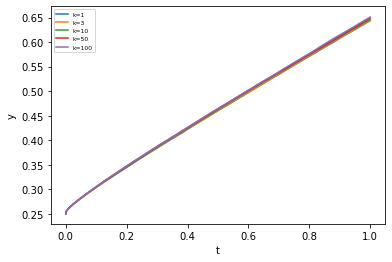

In [5]:


name = "10-50-100-50-100-10000-0-0.0-2.0-1.0-2.0-5.0-0.01"

if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
    
from plotting import * 
method_list = ['TS-Bayes_errors','TS-Bayes_lambda_mins', 'TS-Bayes_lambda_maxs','TS-Bayes_log_maxs_over_mins', 'TS-Bayes_thinnesses',  'TS-Bayes_lambdas_second', 'TS-Bayes_lambdas_third']



for method in method_list:
    save_path = '../plots26/'+method+'/'
    isExist = os.path.exists(save_path)
    if not isExist:
        os.makedirs(save_path)

    df = pd.read_csv ('../plots/all-last-'+name+'.csv')
    plot_last_iter(df,'d' ,method,'d','y','k',save_path+name+'-1.jpg' )
    # TS-Bayes_errors, TS-Freq_errors, TS-Improved_errors, TS-Thinness_errors, TS-ThinnessDirected_errors

    df = pd.read_csv ('../plots/all-'+name+'.csv')
    plot_sample_path(df,'d' ,method,'t','y','d','k',save_path, name+'-2.jpg',1 )



[  1   3  10  50 100]
0     754718.923378
1     474624.924369
2       1040.148826
3        482.074510
4        369.893681
5        359.632764
6        148.985788
7        217.751329
8        217.512375
9        148.608094
10       140.180525
11       105.682610
12        80.808461
13        73.118244
14        66.407354
15        65.548897
16        62.674752
17        64.004666
18        54.855219
19        52.574456
20        49.355541
21        43.077298
22        37.637595
23        41.759115
24        42.950450
25        38.743162
26        36.654996
27        37.938762
28        36.240331
29        36.247554
Name: TS-Bayes_errors_mean, dtype: float64
30    343420.525103
31    163540.755906
32      6071.706199
33      1685.012020
34       977.786416
35       215.357581
36       179.384041
37       197.665390
38       121.405986
39       110.756644
40       104.411611
41        72.303495
42        67.873055
43        56.067656
44        58.858007
45        60.919745
46        62.14

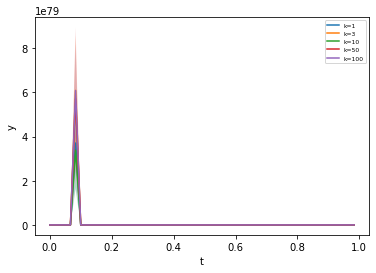

In [1]:


name = "20220909-032527-10-3-6-3-100-60-0-0.0-1000.0-1.0-2.0-5.0-0.1"

if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
    
from plotting import * 
method_list = ['TS-Bayes_errors','TS-Bayes_lambda_mins', 'TS-Bayes_lambda_maxs','TS-Bayes_log_maxs_over_mins', 'TS-Bayes_thinnesses',  'TS-Bayes_lambdas_second', 'TS-Bayes_lambdas_third', 'TS-Bayes_biases', 'TS-Bayes_variances','TS-Bayes_risks']



for method in method_list:
    save_path = '../plots27/'+method+'/'
    isExist = os.path.exists(save_path)
    if not isExist:
        os.makedirs(save_path)

    df = pd.read_csv ('../plots/all-last-'+name+'.csv')
    plot_last_iter(df,'d' ,method,'d','y','k',save_path+name+'-1.jpg' )
    # TS-Bayes_errors, TS-Freq_errors, TS-Improved_errors, TS-Thinness_errors, TS-ThinnessDirected_errors

    df = pd.read_csv ('../plots/all-'+name+'.csv')
    plot_sample_path(df,'d' ,method,'t','y','d','k',save_path, name+'-2.jpg',1 )



[  1   3  10  50 100]
0      1.017035e+06
1      1.005558e+06
2      9.867327e+05
3      9.605770e+05
4      9.530380e+05
           ...     
495    3.447522e+01
496    3.435110e+01
497    3.432718e+01
498    3.454106e+01
499    3.439187e+01
Name: TS-Bayes_errors_mean, Length: 500, dtype: float64
500    998338.288430
501    965126.466950
502    949296.038068
503    922563.437987
504    906042.298178
           ...      
995        32.994093
996        32.935320
997        33.036672
998        33.058244
999        32.947645
Name: TS-Bayes_errors_mean, Length: 500, dtype: float64
1000    870394.980557
1001    859350.023636
1002    846762.380075
1003    817204.043368
1004    796307.928315
            ...      
1495        37.390198
1496        37.204045
1497        37.589924
1498        37.484284
1499        37.475878
Name: TS-Bayes_errors_mean, Length: 500, dtype: float64
1500    1.045959e+06
1501    1.036257e+06
1502    1.017851e+06
1503    1.003466e+06
1504    9.835138e+05
            

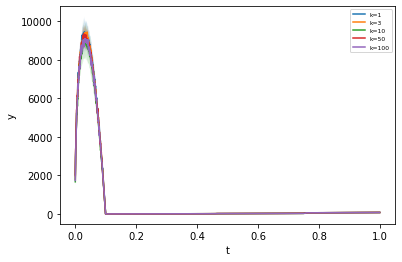

In [2]:


name = "20220909-031636-10-50-200-50-100-2000-0-0.0-1000.0-1.0-2.0-5.0-0.1"

if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
    
from plotting import * 
method_list = ['TS-Bayes_errors','TS-Bayes_lambda_mins', 'TS-Bayes_lambda_maxs','TS-Bayes_log_maxs_over_mins', 'TS-Bayes_thinnesses',  'TS-Bayes_lambdas_second', 'TS-Bayes_lambdas_third', 'TS-Bayes_biases', 'TS-Bayes_variances','TS-Bayes_risks']



for method in method_list:
    save_path = '../plots28/'+method+'/'
    isExist = os.path.exists(save_path)
    if not isExist:
        os.makedirs(save_path)

    df = pd.read_csv ('../plots/all-last-'+name+'.csv')
    plot_last_iter(df,'d' ,method,'d','y','k',save_path+name+'-1.jpg' )
    # TS-Bayes_errors, TS-Freq_errors, TS-Improved_errors, TS-Thinness_errors, TS-ThinnessDirected_errors

    df = pd.read_csv ('../plots/all-'+name+'.csv')
    plot_sample_path(df,'d' ,method,'t','y','d','k',save_path, name+'-2.jpg',1 )



[  1   3  10  50 100]
index: 1,  x: [10 20 30 40 50], y: [2.88896608 3.43067446 3.51131992 3.07241002 3.33658818], se: [0.31222215 0.46890939 0.29077422 0.14874724 0.20457096]
index: 3,  x: [10 20 30 40 50], y: [3.1527986  2.90001345 3.1363815  2.73978641 2.931113  ], se: [0.29736783 0.27426605 0.19659497 0.24701511 0.17389669]
index: 10,  x: [10 20 30 40 50], y: [3.80297988 3.18781735 2.95616848 2.63217436 3.15260257], se: [0.56700785 0.28749264 0.3462762  0.15798554 0.26701141]
index: 50,  x: [10 20 30 40 50], y: [4.03554556 3.18528694 3.76117392 3.36369366 2.96815262], se: [0.68619619 0.33114502 0.31018126 0.22195275 0.24162881]
index: 100,  x: [10 20 30 40 50], y: [5.11839689 3.23689416 3.68923449 3.71031676 3.42688377], se: [0.6962305  0.39149377 0.38764243 0.33870972 0.22962102]
[  1   3  10  50 100]
index: 1,  x: [10 20 30 40 50], y: [0.28233507 0.2779973  0.27499232 0.27296036 0.2730269 ], se: [0.00200306 0.00112355 0.00120794 0.0011033  0.00042279]
index: 3,  x: [10 20 30 40 5

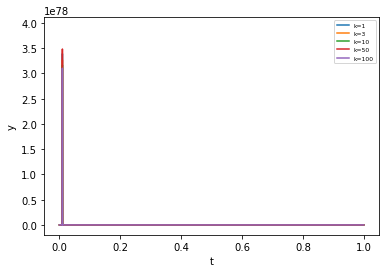

In [18]:

import sys
import os


name = "20220909-034232-10-10-50-10-100-5000-0-0.0-1000.0-1.0-2.0-5.0-0.01"

if 'plotting' in sys.modules:  
    del sys.modules["plotting"]
    
from plotting import * 
method_list = ['TS-Bayes_errors','TS-Bayes_lambda_mins', 'TS-Bayes_lambda_maxs','TS-Bayes_log_maxs_over_mins', 'TS-Bayes_thinnesses',  'TS-Bayes_lambdas_second', 'TS-Bayes_lambdas_third', 'TS-Bayes_biases', 'TS-Bayes_variances','TS-Bayes_risks']



for method in method_list:
    save_path = '../plots32/'+method+'/'
    isExist = os.path.exists(save_path)
    if not isExist:
        os.makedirs(save_path)

    df = pd.read_csv ('../plots/all-last-'+name+'.csv')
    plot_last_iter(df,'d' ,method,'d','y','k',save_path+name+'-1.jpg' )
    # TS-Bayes_errors, TS-Freq_errors, TS-Improved_errors, TS-Thinness_errors, TS-ThinnessDirected_errors

    df = pd.read_csv ('../plots/all-'+name+'.csv')
    plot_sample_path(df,'d' ,method,'t','y','d','k',save_path, name+'-2.jpg',1 )



[  1   3  10  50 100]
index: 1,  x: [10 20 30 40 50], y: [1.73970686 1.69789514 1.8796862  1.65259989 1.7092098 ], se: [0.18962402 0.18041316 0.16875516 0.08943936 0.08401688]
index: 3,  x: [10 20 30 40 50], y: [1.88598245 1.66202311 1.63123018 1.8131458  1.84577722], se: [0.24412961 0.13376432 0.14377566 0.13788517 0.07092077]
index: 10,  x: [10 20 30 40 50], y: [1.76633878 1.88185989 1.78080766 1.60310062 1.80824577], se: [0.23785806 0.19545466 0.09147612 0.08132847 0.08238635]
index: 50,  x: [10 20 30 40 50], y: [1.53222889 1.6969162  1.71348205 1.86814042 1.76074871], se: [0.23950561 0.13648563 0.16121764 0.10022839 0.09794941]
index: 100,  x: [10 20 30 40 50], y: [1.52749092 1.75876081 1.89791131 1.5862188  1.57407097], se: [0.10254918 0.14273513 0.1781371  0.0952827  0.09692942]
[  1   3  10  50 100]
index: 1,  x: [10 20 30 40 50], y: [0.53233407 0.5279963  0.52499132 0.52295936 0.5230259 ], se: [0.00200306 0.00112355 0.00120794 0.0011033  0.00042279]
index: 3,  x: [10 20 30 40 5

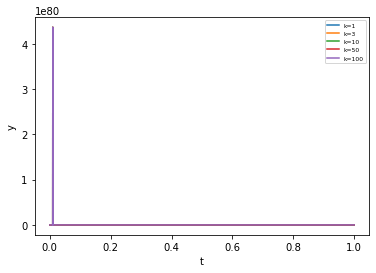

In [17]:

import sys
import os

name = "20220909-035807-10-10-50-10-100-5000-0-0.0-2.0-1.0-2.0-5.0-0.01"

if 'plotting' in sys.modules:  
    del sys.modules["plotting"]

from plotting import * 

method_list = ['TS-Bayes_errors','TS-Bayes_lambda_mins', 'TS-Bayes_lambda_maxs','TS-Bayes_log_maxs_over_mins', 'TS-Bayes_thinnesses',  'TS-Bayes_lambdas_second', 'TS-Bayes_lambdas_third', 'TS-Bayes_biases', 'TS-Bayes_variances','TS-Bayes_risks']



for method in method_list:
    save_path = f'../plots31/{method}/'
    isExist = os.path.exists(save_path)
    if not isExist:
        os.makedirs(save_path)

    df = pd.read_csv(f'../plots/all-last-{name}.csv')
    plot_last_iter(df,'d' ,method,'d','y','k',save_path+name+'-1.jpg' )

    df = pd.read_csv(f'../plots/all-{name}.csv')
    plot_sample_path(df, 'd', method, 't', 'y', 'd', 'k', save_path, f'{name}-2.jpg', 1)



[  1   3  10  50 100]
index: 1,  x: [10 20 30 40 50], y: [34.97593256 30.75240893 33.32109998 30.51701778 30.44159448], se: [3.97296563 4.44062188 2.82796705 2.00741097 1.57165359]
index: 3,  x: [10 20 30 40 50], y: [33.54155913 35.03197692 36.51177574 33.74693736 31.89443273], se: [3.85487737 2.53318692 2.6718466  2.99884066 3.06862603]
index: 10,  x: [10 20 30 40 50], y: [38.45320957 34.0463178  33.77811264 34.93707652 32.63162319], se: [9.29854694 2.81268882 3.99717328 3.44887307 1.96622928]
index: 50,  x: [10 20 30 40 50], y: [38.74294683 38.02075367 30.87321174 37.01514143 36.06601917], se: [5.06118477 4.33362314 2.46217272 2.569751   2.39880986]
index: 100,  x: [10 20 30 40 50], y: [36.14731507 39.15491252 35.83721648 38.53031229 32.94751558], se: [6.59160484 3.33077601 2.12873469 2.42003701 2.54739854]
[  1   3  10  50 100]
index: 1,  x: [10 20 30 40 50], y: [0.01732416 0.01748273 0.01677417 0.01626426 0.01629725], se: [0.00055464 0.00018024 0.00019524 0.00025697 0.00017568]
ind

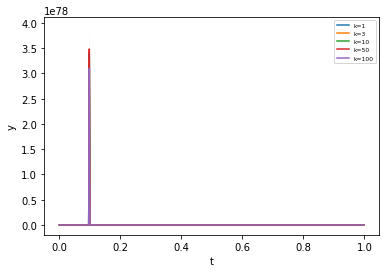

In [19]:

import sys
import os

name = "20220909-045749-10-10-50-10-100-500-0-0.0-1000.0-1.0-2.0-5.0-0.1"

if 'plotting' in sys.modules:  
    del sys.modules["plotting"]

from plotting import * 

method_list = ['TS-Bayes_errors','TS-Bayes_lambda_mins', 'TS-Bayes_lambda_maxs','TS-Bayes_log_maxs_over_mins', 'TS-Bayes_thinnesses',  'TS-Bayes_lambdas_second', 'TS-Bayes_lambdas_third', 'TS-Bayes_biases', 'TS-Bayes_variances','TS-Bayes_risks']



for method in method_list:
    save_path = f'../plots33/{method}/'
    isExist = os.path.exists(save_path)
    if not isExist:
        os.makedirs(save_path)

    df = pd.read_csv(f'../plots/all-last-{name}.csv')
    plot_last_iter(df,'d' ,method,'d','y','k',save_path+name+'-1.jpg' )

    df = pd.read_csv(f'../plots/all-{name}.csv')
    plot_sample_path(df, 'd', method, 't', 'y', 'd', 'k', save_path, f'{name}-2.jpg', 1)



[  1   3  10  50 100]
index: 1,  x: [10 20 30 40 50], y: [3.59846698 3.59948642 3.3612844  3.41087479 3.41780677], se: [0.34639887 0.41126563 0.35290344 0.28850571 0.27597266]
index: 3,  x: [10 20 30 40 50], y: [4.52481918 3.83878704 3.47024224 3.6838855  3.89134806], se: [0.64197654 0.41694494 0.2143031  0.18389805 0.23726675]
index: 10,  x: [10 20 30 40 50], y: [3.52719968 3.48487732 3.92071217 3.51834949 3.42740645], se: [0.43952667 0.34805081 0.2190289  0.15733506 0.17824354]
index: 50,  x: [10 20 30 40 50], y: [3.47588199 3.37897225 3.58641604 3.71284704 3.47087574], se: [0.70727797 0.2922381  0.1097372  0.27838979 0.23503836]
index: 100,  x: [10 20 30 40 50], y: [4.27356075 3.09346542 3.71119506 3.3199142  3.57894332], se: [0.52440963 0.32042506 0.34076497 0.14744268 0.17911994]
[  1   3  10  50 100]
index: 1,  x: [10 20 30 40 50], y: [0.26732316 0.26748173 0.26677317 0.26626326 0.26629625], se: [0.00055464 0.00018024 0.00019524 0.00025697 0.00017568]
index: 3,  x: [10 20 30 40 5

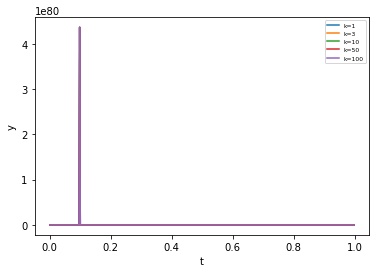

In [20]:

import sys
import os

name = "20220909-045749-10-10-50-10-100-500-0-0.0-2.0-1.0-2.0-5.0-0.1"

if 'plotting' in sys.modules:  
    del sys.modules["plotting"]

from plotting import * 

method_list = ['TS-Bayes_errors','TS-Bayes_lambda_mins', 'TS-Bayes_lambda_maxs','TS-Bayes_log_maxs_over_mins', 'TS-Bayes_thinnesses',  'TS-Bayes_lambdas_second', 'TS-Bayes_lambdas_third', 'TS-Bayes_biases', 'TS-Bayes_variances','TS-Bayes_risks']



for method in method_list:
    save_path = f'../plots34/{method}/'
    isExist = os.path.exists(save_path)
    if not isExist:
        os.makedirs(save_path)

    df = pd.read_csv(f'../plots/all-last-{name}.csv')
    plot_last_iter(df,'d' ,method,'d','y','k',save_path+name+'-1.jpg' )

    df = pd.read_csv(f'../plots/all-{name}.csv')
    plot_sample_path(df, 'd', method, 't', 'y', 'd', 'k', save_path, f'{name}-2.jpg', 1)



[  1   3  10  50 100]
index: 1,  x: [10 20 30 40 50], y: [34.97593256 30.75240893 33.32109998 30.51701778 30.44159448], se: [3.97296563 4.44062188 2.82796705 2.00741097 1.57165359]
index: 3,  x: [10 20 30 40 50], y: [33.54155913 35.03197692 36.51177574 33.74693736 31.89443273], se: [3.85487737 2.53318692 2.6718466  2.99884066 3.06862603]
index: 10,  x: [10 20 30 40 50], y: [38.45320957 34.0463178  33.77811264 34.93707652 32.63162319], se: [9.29854694 2.81268882 3.99717328 3.44887307 1.96622928]
index: 50,  x: [10 20 30 40 50], y: [38.74294683 38.02075367 30.87321174 37.01514143 36.06601917], se: [5.06118477 4.33362314 2.46217272 2.569751   2.39880986]
index: 100,  x: [10 20 30 40 50], y: [36.14731507 39.15491252 35.83721648 38.53031229 32.94751558], se: [6.59160484 3.33077601 2.12873469 2.42003701 2.54739854]
[  1   3  10  50 100]
index: 1,  x: [10 20 30 40 50], y: [0.01732416 0.01748273 0.01677417 0.01626426 0.01629725], se: [0.00055464 0.00018024 0.00019524 0.00025697 0.00017568]
ind

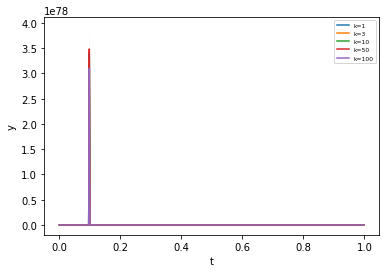

In [21]:

import sys
import os

name = "20220909-064901-10-10-50-10-100-500-0-0.0-1000.0-1.0-2.0-5.0-0.1"

if 'plotting' in sys.modules:  
    del sys.modules["plotting"]

from plotting import * 

method_list = ['TS-Bayes_errors','TS-Bayes_lambda_mins', 'TS-Bayes_lambda_maxs','TS-Bayes_log_maxs_over_mins', 'TS-Bayes_thinnesses',  'TS-Bayes_lambdas_second', 'TS-Bayes_lambdas_third', 'TS-Bayes_biases', 'TS-Bayes_variances','TS-Bayes_risks']



for method in method_list:
    save_path = f'../plots40/{method}/'
    isExist = os.path.exists(save_path)
    if not isExist:
        os.makedirs(save_path)

    df = pd.read_csv(f'../plots/all-last-{name}.csv')
    plot_last_iter(df,'d' ,method,'d','y','k',save_path+name+'-1.jpg' )

    df = pd.read_csv(f'../plots/all-{name}.csv')
    plot_sample_path(df, 'd', method, 't', 'y', 'd', 'k', save_path, f'{name}-2.jpg', 1)



[  1   3  10  50 100]
index: 1,  x: [10 20 30 40 50], y: [3.59846698 3.59948642 3.3612844  3.41087479 3.41780677], se: [0.34639887 0.41126563 0.35290344 0.28850571 0.27597266]
index: 3,  x: [10 20 30 40 50], y: [4.52481918 3.83878704 3.47024224 3.6838855  3.89134806], se: [0.64197654 0.41694494 0.2143031  0.18389805 0.23726675]
index: 10,  x: [10 20 30 40 50], y: [3.52719968 3.48487732 3.92071217 3.51834949 3.42740645], se: [0.43952667 0.34805081 0.2190289  0.15733506 0.17824354]
index: 50,  x: [10 20 30 40 50], y: [3.47588199 3.37897225 3.58641604 3.71284704 3.47087574], se: [0.70727797 0.2922381  0.1097372  0.27838979 0.23503836]
index: 100,  x: [10 20 30 40 50], y: [4.27356075 3.09346542 3.71119506 3.3199142  3.57894332], se: [0.52440963 0.32042506 0.34076497 0.14744268 0.17911994]
[  1   3  10  50 100]
index: 1,  x: [10 20 30 40 50], y: [0.26732316 0.26748173 0.26677317 0.26626326 0.26629625], se: [0.00055464 0.00018024 0.00019524 0.00025697 0.00017568]
index: 3,  x: [10 20 30 40 5

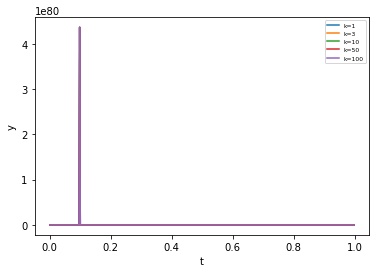

In [22]:

import sys
import os

name = "20220909-064907-10-10-50-10-100-500-0-0.0-2.0-1.0-2.0-5.0-0.1"

if 'plotting' in sys.modules:  
    del sys.modules["plotting"]

from plotting import * 

method_list = ['TS-Bayes_errors','TS-Bayes_lambda_mins', 'TS-Bayes_lambda_maxs','TS-Bayes_log_maxs_over_mins', 'TS-Bayes_thinnesses',  'TS-Bayes_lambdas_second', 'TS-Bayes_lambdas_third', 'TS-Bayes_biases', 'TS-Bayes_variances','TS-Bayes_risks']



for method in method_list:
    save_path = f'../plots41/{method}/'
    isExist = os.path.exists(save_path)
    if not isExist:
        os.makedirs(save_path)

    df = pd.read_csv(f'../plots/all-last-{name}.csv')
    plot_last_iter(df,'d' ,method,'d','y','k',save_path+name+'-1.jpg' )

    df = pd.read_csv(f'../plots/all-{name}.csv')
    plot_sample_path(df, 'd', method, 't', 'y', 'd', 'k', save_path, f'{name}-2.jpg', 1)



[  1   3  10  50 100]
index: 1,  x: [ 50 100 150 200 250 300], y: [34.39186581 34.21812728 34.08633903 34.20563387 32.1861204  33.65292579], se: [2.10745792 1.31628161 1.30167796 1.0570118  0.59531419 0.64865832]
index: 3,  x: [ 50 100 150 200 250 300], y: [32.947645   32.62201199 32.95525717 31.83322874 33.63050314 32.9822642 ], se: [2.88858279 1.23486901 1.24093668 1.20885169 1.01519543 0.84855275]
index: 10,  x: [ 50 100 150 200 250 300], y: [37.47587845 34.10771023 32.65951298 33.90391946 34.59245931 33.2479701 ], se: [2.34373017 1.45229477 1.33655338 1.47261834 0.78573105 0.52935959]
index: 50,  x: [ 50 100 150 200 250 300], y: [33.47120314 31.71448797 34.42208555 33.42110638 33.450664   33.42917048], se: [2.64835144 1.53540739 1.329353   1.18869442 0.9386429  0.94554505]
index: 100,  x: [ 50 100 150 200 250 300], y: [30.69279071 36.57039745 32.32642228 32.43323132 33.55798136 34.1496824 ], se: [1.66884751 2.01714022 1.16260272 0.40721378 1.17570146 1.20461114]
[  1   3  10  50 10

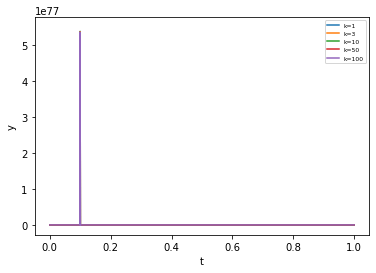

In [3]:



import sys
import os

name = "20220909-144309-10-50-300-50-100-3000-0-0.0-1000.0-1.0-2.0-5.0-0.1"

if 'plotting' in sys.modules:  
    del sys.modules["plotting"]

from plotting import * 

method_list = ['TS-Bayes_errors','TS-Bayes_lambda_mins', 'TS-Bayes_lambda_maxs','TS-Bayes_log_maxs_over_mins', 'TS-Bayes_thinnesses',  'TS-Bayes_lambdas_second', 'TS-Bayes_lambdas_third', 'TS-Bayes_biases', 'TS-Bayes_variances','TS-Bayes_risks']



for method in method_list:
    save_path = f'../plots42/{method}/'
    isExist = os.path.exists(save_path)
    if not isExist:
        os.makedirs(save_path)

    df = pd.read_csv(f'../plots/all-last-{name}.csv')
    plot_last_iter(df,'d' ,method,'d','y','k',save_path+name+'-1.jpg' )

    df = pd.read_csv(f'../plots/all-{name}.csv')
    plot_sample_path(df, 'd', method, 't', 'y', 'd', 'k', save_path, f'{name}-2.jpg', 1)



[  1   3  10  50 100]
index: 1,  x: [ 50 100 150 200 250 300], y: [34.39186581 34.21812728 34.08633903 34.20563387 32.1861204  33.65292579], se: [2.10745792 1.31628161 1.30167796 1.0570118  0.59531419 0.64865832]
index: 3,  x: [ 50 100 150 200 250 300], y: [32.947645   32.62201199 32.95525717 31.83322874 33.63050314 32.9822642 ], se: [2.88858279 1.23486901 1.24093668 1.20885169 1.01519543 0.84855275]
index: 10,  x: [ 50 100 150 200 250 300], y: [37.47587845 34.10771023 32.65951298 33.90391946 34.59245931 33.2479701 ], se: [2.34373017 1.45229477 1.33655338 1.47261834 0.78573105 0.52935959]
index: 50,  x: [ 50 100 150 200 250 300], y: [33.47120314 31.71448797 34.42208555 33.42110638 33.450664   33.42917048], se: [2.64835144 1.53540739 1.329353   1.18869442 0.9386429  0.94554505]
index: 100,  x: [ 50 100 150 200 250 300], y: [30.69279071 36.57039745 32.32642228 32.43323132 33.55798136 34.1496824 ], se: [1.66884751 2.01714022 1.16260272 0.40721378 1.17570146 1.20461114]
[  1   3  10  50 10

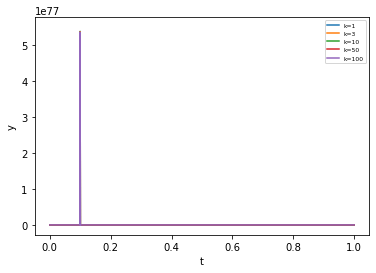

In [4]:

import sys
import os

name = "20220909-144514-10-50-300-50-100-3000-0-0.0-1000.0-1.0-2.0-5.0-0.1"

if 'plotting' in sys.modules:  
    del sys.modules["plotting"]

from plotting import * 

method_list = ['TS-Bayes_errors','TS-Bayes_lambda_mins', 'TS-Bayes_lambda_maxs','TS-Bayes_log_maxs_over_mins', 'TS-Bayes_thinnesses',  'TS-Bayes_lambdas_second', 'TS-Bayes_lambdas_third', 'TS-Bayes_biases', 'TS-Bayes_variances','TS-Bayes_risks']



for method in method_list:
    save_path = f'../plots43/{method}/'
    isExist = os.path.exists(save_path)
    if not isExist:
        os.makedirs(save_path)

    df = pd.read_csv(f'../plots/all-last-{name}.csv')
    plot_last_iter(df,'d' ,method,'d','y','k',save_path+name+'-1.jpg' )

    df = pd.read_csv(f'../plots/all-{name}.csv')
    plot_sample_path(df, 'd', method, 't', 'y', 'd', 'k', save_path, f'{name}-2.jpg', 1)



[  1   3  10  50 100]
index: 1,  x: [ 50 100 150 200], y: [34.39186581 34.21812728 34.08633903 34.20563387], se: [2.10745792 1.31628161 1.30167796 1.0570118 ]
index: 3,  x: [ 50 100 150 200], y: [32.947645   32.62201199 32.95525717 31.83322874], se: [2.88858279 1.23486901 1.24093668 1.20885169]
index: 10,  x: [ 50 100 150 200], y: [37.47587845 34.10771023 32.65951298 33.90391946], se: [2.34373017 1.45229477 1.33655338 1.47261834]
index: 50,  x: [ 50 100 150 200], y: [33.47120314 31.71448797 34.42208555 33.42110638], se: [2.64835144 1.53540739 1.329353   1.18869442]
index: 100,  x: [ 50 100 150 200], y: [30.69279071 36.57039745 32.32642228 32.43323132], se: [1.66884751 2.01714022 1.16260272 0.40721378]
[  1   3  10  50 100]
index: 1,  x: [ 50 100 150 200], y: [0.01628763 0.01601853 0.01597578 0.01599307], se: [1.96085099e-04 6.98709749e-05 8.02777782e-05 5.49618811e-05]
index: 3,  x: [ 50 100 150 200], y: [0.01643233 0.01603404 0.0161051  0.01577653], se: [1.49005582e-04 1.45588410e-04 

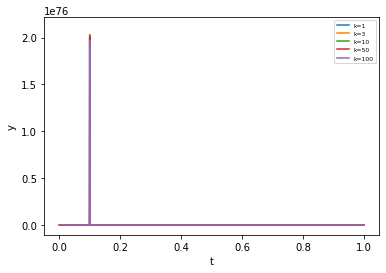

In [5]:

import sys
import os

name = "20220913-163819-10-50-200-50-100-2000-0-0.0-1000.0-1.0-2.0-5.0-0.1"

if 'plotting' in sys.modules:  
    del sys.modules["plotting"]

from plotting import * 

method_list = ['TS-Bayes_errors','TS-Bayes_lambda_mins', 'TS-Bayes_lambda_maxs','TS-Bayes_log_maxs_over_mins', 'TS-Bayes_thinnesses',  'TS-Bayes_lambdas_second', 'TS-Bayes_lambdas_third', 'TS-Bayes_biases', 'TS-Bayes_variances','TS-Bayes_risks']



for method in method_list:
    save_path = f'../plots44/{method}/'
    isExist = os.path.exists(save_path)
    if not isExist:
        os.makedirs(save_path)

    df = pd.read_csv(f'../plots/all-last-{name}.csv')
    plot_last_iter(df,'d' ,method,'d','y','k',save_path+name+'-1.jpg' )

    df = pd.read_csv(f'../plots/all-{name}.csv')
    plot_sample_path(df, 'd', method, 't', 'y', 'd', 'k', save_path, f'{name}-2.jpg', 1)



[  1   3  10  50 100]
index: 1,  x: [ 50 100 150 200], y: [ 335.72945671 1094.7593131  2504.36178644 4365.65186599], se: [ 30.43706349  71.20629281 107.60800166 136.92308853]
index: 3,  x: [ 50 100 150 200], y: [ 249.11309139  771.15428185 1563.4008295  3024.57359884], se: [25.916377   26.81161767 59.94991945 78.50046565]
index: 10,  x: [ 50 100 150 200], y: [ 82.0856624  243.87081607 496.19956174 840.62829721], se: [ 3.98498368 10.3228691  20.67077544 44.87391924]
index: 50,  x: [ 50 100 150 200], y: [ 56.82203775 108.29004808 198.73868493 328.52130943], se: [ 3.43418141  3.64816221  7.28358373 11.62548661]
index: 100,  x: [ 50 100 150 200], y: [ 46.49422455  93.37307329 159.93286459 240.07418322], se: [2.50075028 5.50563299 9.54443986 6.41885623]
[  1   3  10  50 100]
index: 1,  x: [ 50 100 150 200], y: [0.01678663 0.01701753 0.01747478 0.01799207], se: [1.96085099e-04 6.98709749e-05 8.02777782e-05 5.49618811e-05]
index: 3,  x: [ 50 100 150 200], y: [0.01704177 0.01704008 0.01749892 

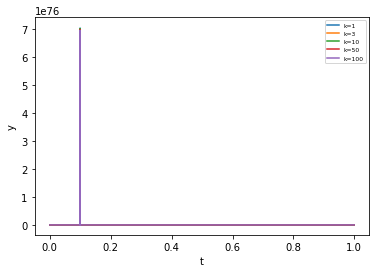

In [6]:



import sys
import os

name = "20220913-171851-10-50-200-50-100-2000-0-0.0-1000.0-1.0-2.0-5.0-0.1"

if 'plotting' in sys.modules:  
    del sys.modules["plotting"]

from plotting import * 

method_list = ['TS-Bayes_errors','TS-Bayes_lambda_mins', 'TS-Bayes_lambda_maxs','TS-Bayes_log_maxs_over_mins', 'TS-Bayes_thinnesses',  'TS-Bayes_lambdas_second', 'TS-Bayes_lambdas_third', 'TS-Bayes_biases', 'TS-Bayes_variances','TS-Bayes_risks']



for method in method_list:
    save_path = f'../plots45/{method}/'
    isExist = os.path.exists(save_path)
    if not isExist:
        os.makedirs(save_path)

    df = pd.read_csv(f'../plots/all-last-{name}.csv')
    plot_last_iter(df,'d' ,method,'d','y','k',save_path+name+'-1.jpg' )

    df = pd.read_csv(f'../plots/all-{name}.csv')
    plot_sample_path(df, 'd', method, 't', 'y', 'd', 'k', save_path, f'{name}-2.jpg', 1)



[  1   3  10  50 100]
index: 1,  x: [ 50 100 150 200], y: [1.04358382 1.01266815 1.01385738 1.01955941], se: [0.03214617 0.01942036 0.01649125 0.01421354]
index: 3,  x: [ 50 100 150 200], y: [0.95262269 0.9580966  0.92760705 0.9245943 ], se: [0.02272788 0.01836809 0.01433094 0.01359803]
index: 10,  x: [ 50 100 150 200], y: [0.70999189 0.7442899  0.74632841 0.73603162], se: [0.0180502  0.01316993 0.01135565 0.00937178]
index: 50,  x: [ 50 100 150 200], y: [0.55816243 0.60656711 0.61629245 0.61215759], se: [0.0118156  0.01080562 0.00771933 0.00797512]
index: 100,  x: [ 50 100 150 200], y: [0.53653418 0.56869338 0.57196787 0.57418045], se: [0.0115793  0.00920803 0.00741893 0.00614543]
[  1   3  10  50 100]
index: 1,  x: [ 50 100 150 200], y: [10.11672806 18.63120148 27.72269842 36.45387787], se: [0.15333665 0.16084662 0.21374445 0.19252635]
index: 3,  x: [ 50 100 150 200], y: [10.4703677  19.21611317 28.11800634 36.65645348], se: [0.14550161 0.18987877 0.19340724 0.21588373]
index: 10,  x

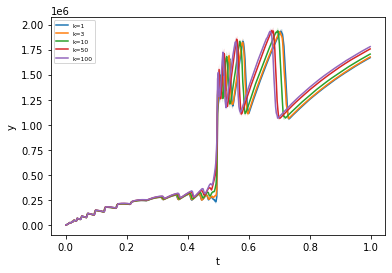

In [33]:
import sys
import os






output_folder_name = 'my_outputs'
output_name = 'dims-50.0-200.0-50.0-prior_sd-1000000.0-noise_sd-1.0-gamma-0.5-radius-1.0-sim-2-k-100-t-400-prior_mu-0.0-thin_thresh-2.0-const_infl-5.0-n-100-time-20220915-221842'
figure_folder_name = f"figures/figures-{output_name}"


if 'plotting' in sys.modules:  
    del sys.modules["plotting"]

from plotting import * 
plot_statistics(output_folder_name, output_name, figure_folder_name, mode = 'd')



In [14]:
os.getcwd()

os.chdir('../')

os.chdir('linear-ts')

In [25]:
def predicted_risk(gamma, radius, noise_sd): 
    #limiting risk of the min-norm ridge estimator for isotropic features 
    #gamma: ratio
    #radius: radius of the coefficient
    #noise_sd: standard deviation of the noise

    print(f"type(gamma)-{type(gamma)}-type(radius)-{type(radius)}-type(noise_sd)-{type(noise_sd)}")
    if gamma == 1:
        raise ValueError('gamma cannot be 1') 
    if gamma < 1:
        bias_ = 0
        variance_ = noise_sd**2 * gamma/(1-gamma) 
    else:
        bias_ = radius**2 * (1 - 1/gamma)
        variance_ = noise_sd**2 * 1 /(gamma - 1)   

    return  [bias_, variance_, bias_+variance_]

In [70]:
predicted_risk(0.5, 1, 1)

type(gamma)-<class 'float'>-type(radius)-<class 'int'>-type(noise_sd)-<class 'int'>


[0, 1.0, 1.0]

predicted_risk(5, 1, 1)

In [29]:
(2*np.sqrt(3))**2

11.999999999999998

[  1   3  10  50 100]
index: 1,  x: [ 50 100 150 200], y: [1.56185083 1.58598552 1.50225882 1.53870457], se: [0.04232296 0.03271531 0.02489372 0.0221584 ]
index: 3,  x: [ 50 100 150 200], y: [1.52366029 1.53085498 1.48071101 1.47468331], se: [0.03830495 0.02654068 0.02270167 0.024192  ]
index: 10,  x: [ 50 100 150 200], y: [1.50234366 1.50853069 1.5621701  1.49781406], se: [0.03397768 0.02770861 0.02417791 0.02452751]
index: 50,  x: [ 50 100 150 200], y: [1.37023154 1.4238009  1.46545208 1.47182917], se: [0.03562906 0.02877225 0.02056479 0.02177628]
index: 100,  x: [ 50 100 150 200], y: [1.32657536 1.42871203 1.44093361 1.47181179], se: [0.03815783 0.03507622 0.02580345 0.0201673 ]
[  1   3  10  50 100]
index: 1,  x: [ 50 100 150 200], y: [2.49779872e-11 4.99417004e-11 7.48932830e-11 9.98387725e-11], se: [7.73381604e-16 1.50784876e-15 1.19060070e-15 1.05530974e-15]
index: 3,  x: [ 50 100 150 200], y: [2.49775415e-11 4.99417369e-11 7.48779194e-11 9.98370316e-11], se: [6.73190796e-16 1.1

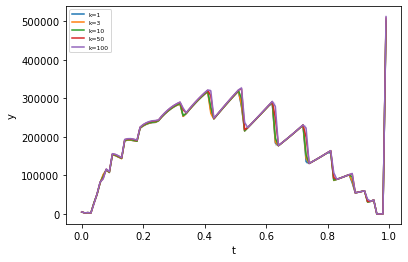

In [34]:
import sys
import os






output_folder_name = 'my_outputs'
output_name = 'dims-50.0-200.0-50.0-prior_sd-1000000.0-noise_sd-1.0-gamma-2.0-radius-1.0-sim-2-k-100-t-100-prior_mu-0.0-thin_thresh-2.0-const_infl-5.0-n-100-time-20220915-201046'
figure_folder_name = f"figures/figures-{output_name}"


if 'plotting' in sys.modules:  
    del sys.modules["plotting"]

from plotting import * 
plot_statistics(output_folder_name, output_name, figure_folder_name, mode = 'd')



[  1   3  10  50 100]
index: 1,  x: [ 50 100 150 200], y: [1.06240136 1.07125361 1.05012048 1.05162599], se: [0.01354243 0.01093561 0.00844435 0.00811586]
index: 3,  x: [ 50 100 150 200], y: [1.05598893 1.05231029 1.03443893 1.04050554], se: [0.01582266 0.00903044 0.0086585  0.00677995]
index: 10,  x: [ 50 100 150 200], y: [1.04768739 1.03972833 1.06320335 1.05943276], se: [0.0127154  0.00985998 0.00828538 0.00827246]
index: 50,  x: [ 50 100 150 200], y: [1.0457825  1.05372724 1.05462935 1.04592876], se: [0.01507906 0.01101923 0.00851512 0.00720266]
index: 100,  x: [ 50 100 150 200], y: [1.01052053 1.04195744 1.02546546 1.05071931], se: [0.01379237 0.01102806 0.0081746  0.00647214]
[  1   3  10  50 100]
index: 1,  x: [ 50 100 150 200], y: [9.97940018e-12 1.99503946e-11 2.99382617e-11 3.99078895e-11], se: [1.44815093e-15 2.85893737e-15 9.46071919e-16 1.68742230e-15]
index: 3,  x: [ 50 100 150 200], y: [9.98224760e-12 1.99491021e-11 2.99394862e-11 3.99061151e-11], se: [9.01641223e-16 2.8

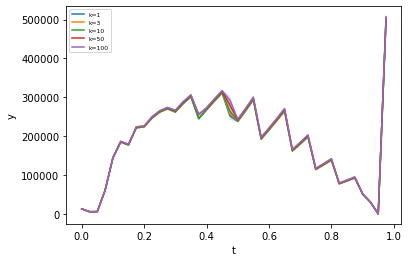

In [35]:
import sys
import os






output_folder_name = 'my_outputs'
output_name = 'dims-50.0-200.0-50.0-prior_sd-1000000.0-noise_sd-1.0-gamma-5.0-radius-1.0-sim-2-k-100-t-40-prior_mu-0.0-thin_thresh-2.0-const_infl-5.0-n-100-time-20220915-192908'
figure_folder_name = f"figures/figures-{output_name}"


if 'plotting' in sys.modules:  
    del sys.modules["plotting"]

from plotting import * 
plot_statistics(output_folder_name, output_name, figure_folder_name, mode = 'd')



[    1    10   100 10000]
index: 1,  x: [ 50 100], y: [0.00187118 0.00111543], se: [1.11455071e-04 3.25455071e-05]
index: 10,  x: [ 50 100], y: [0.02012383 0.01078569], se: [0.00158422 0.00061571]
index: 100,  x: [ 50 100], y: [0.19421293 0.11178345], se: [0.00934952 0.00414651]
index: 10000,  x: [ 50 100], y: [10.92971533  7.15696651], se: [0.72730977 0.32642801]
[    1    10   100 10000]
index: 1,  x: [ 50 100], y: [12074.34419391 48479.87000986], se: [154.77037031 342.85790468]
index: 10,  x: [ 50 100], y: [1186.57027234 4865.01679318], se: [17.65785875 28.34508678]
index: 100,  x: [ 50 100], y: [123.23955173 483.68935519], se: [1.78029803 3.20795982]
index: 10000,  x: [ 50 100], y: [1.6301508  5.50823979], se: [0.01928531 0.02944282]
[    1    10   100 10000]
index: 1,  x: [ 50 100], y: [ 42202.44045961 170785.48298162], se: [ 329.47634778 1050.39652486]
index: 10,  x: [ 50 100], y: [ 6789.51122137 27091.12884132], se: [ 58.50131875 210.28579748]
index: 100,  x: [ 50 100], y: [1456

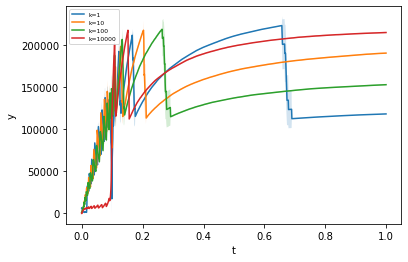

In [66]:

import sys
import os






output_folder_name = 'my_outputs'
output_name = 'dims-50.0-100.0-50.0-gamma-0.1-radius-5.0-prior_sd-1000000.0-noise_sd-1.0-sim-2-k-10000-t-1000-prior_mu-0.0-thin_thresh-2.0-const_infl-5.0-n-10-time-20220916-034752'
figure_folder_name = f"figures/figures-{output_name}"


if 'plotting' in sys.modules:  
    del sys.modules["plotting"]

from plotting import * 
plot_statistics(output_folder_name, output_name, figure_folder_name, mode = 'd')



In [23]:


import sys
import os






output_folder_name = 'my_outputs'
output_name = 'dims-50.0-100.0-50.0-gamma-0.5-radius-1.0-prior_sd-1000000.0-noise_sd-1.0-sim-2-k-10000-t-200-prior_mu-0.0-thin_thresh-2.0-const_infl-5.0-n-10-time-20220920-020443'
figure_folder_name = f"figures/figures-{output_name}"


if 'plotting' in sys.modules:  
    del sys.modules["plotting"]

from plotting import * 
plot_statistics(output_folder_name, output_name, figure_folder_name, mode = 'd')



FileNotFoundError: [Errno 2] No such file or directory: 'my_outputs/all-last-dims-50.0-100.0-50.0-gamma-0.5-radius-1.0-prior_sd-1000000.0-noise_sd-1.0-sim-2-k-10000-t-200-prior_mu-0.0-thin_thresh-2.0-const_infl-5.0-n-10-time-20220920-020443.csv'

In [61]:
import numpy.random as npr
import numpy.linalg as npl

radius = 1
array = npr.randn(100, 3)

array = radius * array / npl.norm(array, ord=2, axis=1, keepdims=True)
array

array([[-0.24570319, -0.48030002,  0.84198684],
       [-0.82791862,  0.55570677, -0.07576773],
       [ 0.30539242, -0.74889337,  0.5881277 ],
       [ 0.63038732,  0.67769672, -0.37860135],
       [ 0.15262482, -0.85316701,  0.4988103 ],
       [-0.11122714, -0.76293421, -0.63683586],
       [-0.43687486,  0.17749682, -0.88183629],
       [-0.39635823,  0.80578388,  0.4400142 ],
       [ 0.9323297 ,  0.00961611,  0.36148147],
       [ 0.77302255,  0.59728671, -0.21373988],
       [ 0.1277764 , -0.11956689,  0.98456942],
       [-0.25251467,  0.86424926,  0.43509719],
       [ 0.21679281,  0.69198474,  0.68859132],
       [ 0.26475349, -0.39371257, -0.88028177],
       [-0.97372987,  0.22187393,  0.05120643],
       [ 0.54306947,  0.10209241,  0.83345827],
       [-0.45144204,  0.87386618,  0.18043832],
       [-0.78957872, -0.1529815 , -0.59427444],
       [-0.26062509, -0.81484453,  0.5177866 ],
       [-0.0206079 , -0.0694392 ,  0.99737331],
       [ 0.02238752, -0.9889846 , -0.146

In [7]:
import numpy as np

a =  np.array([-0.03282889,  0.13213776,  0.26210519,  0.43003415,  0.17026654, -0.12827673, 0.35299081,  0.04185799,  0.27411373, -0.6934658 ])
b =  np.array([ 0.1019718,  -0.15709193, -0.26657551, -0.18642179, -0.27836017, -0.11251442, 0.47771177,  0.26796196,  0.11646471, -0.6748246 ])


(b @ a)**2/ np.linalg.norm(b)**2

0.22337927874768443

In [15]:
import numpy as np

a =  np.array([-0.69250157, -0.13347435, -0.70896133])
b =  np.array([0.650842,   0.02518821, -0.75879526])


(b.T @ a)**2/ np.linalg.norm(b)**2

0.007036761991681408

In [16]:
np.linalg.norm(b)**2

1.0000000014854717

In [17]:
a = np.random.randn(9, 6) + 1j*np.random.randn(9, 6)


u, s, vh = np.linalg.svd(a, full_matrices=True)
u.shape, s.shape, vh.shape
((9, 9), (6,), (6, 6))
np.allclose(a, np.dot(u[:, :6] * s, vh))
True
smat = np.zeros((9, 6), dtype=complex)
smat[:6, :6] = np.diag(s)
np.allclose(a, np.dot(u, np.dot(smat, vh)))

True

In [21]:
np.linalg.norm(vh,axis=0)

array([1., 1., 1., 1., 1., 1.])

In [62]:
npl.norm(array, ord=2, axis=1, keepdims=True)

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [29]:
os.chdir('src')

[    1    10   100  1000 10000]
index: 1,  x: [ 50 100], y: [0.09869913 0.10485158], se: [0.00694583 0.0038764 ]
index: 10,  x: [ 50 100], y: [0.09564901 0.09838224], se: [0.00542082 0.0049825 ]
index: 100,  x: [ 50 100], y: [0.08794952 0.10314553], se: [0.00411254 0.00395186]
index: 1000,  x: [ 50 100], y: [0.08953951 0.09685193], se: [0.00459477 0.00462313]
index: 10000,  x: [ 50 100], y: [0.08660615 0.10057371], se: [0.00581903 0.00482928]
[    1    10   100  1000 10000]
index: 1,  x: [ 50 100], y: [244.08611125 474.80907264], se: [3.77371611 4.63435147]
index: 10,  x: [ 50 100], y: [251.29118554 487.42827935], se: [2.96041276 2.77287736]
index: 100,  x: [ 50 100], y: [264.60566168 496.23961677], se: [2.13672718 5.59497862]
index: 1000,  x: [ 50 100], y: [272.95520657 518.77781062], se: [2.64621952 4.13956423]
index: 10000,  x: [ 50 100], y: [284.90321759 520.03689504], se: [3.24756965 2.58717323]
[    1    10   100  1000 10000]
index: 1,  x: [ 50 100], y: [ 847.049115   1715.524483

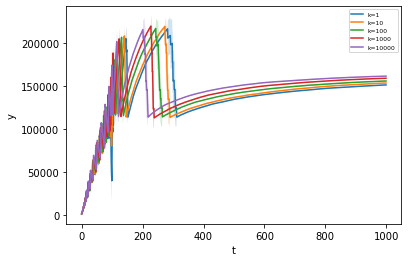

In [33]:


import sys
import os






output_folder_name = '../my_outputs'
output_name = 'dims-50.0-100.0-50.0-gamma-0.1-radius-1.0-prior_sd-1000000.0-noise_sd-1.0-sim-2-k-10000-t-1000-prior_mu-0.0-thin_thresh-2.0-const_infl-5.0-n-10-time-20220920-022036'
figure_folder_name = f"../figures/figures-{output_name}"


if 'plotting' in sys.modules:  
    del sys.modules["plotting"]

from plotting import * 
plot_statistics(output_folder_name, output_name, figure_folder_name, mode = 'd')



In [112]:
import numpy.linalg as npl
import numpy.random as npr
def uniform_on_ball(k, d, radius = 1, state=npr):
    def _rand():
        random_directions = state.normal(size=(k,d))
        random_directions /= npl.norm(random_directions, axis=1, keepdims=True)
        random_radii = state.random((k,1)) ** (1/d)
        print(random_directions)
        print(npl.norm(random_directions,axis=1, keepdims=True))
        print(random_radii)
        return radius * ( random_radii * random_directions  )

    return _rand

In [141]:
a = uniform_on_ball(2,3,3)()
print(f"a = {a}")
npl.norm(a,axis=1, keepdims=True)

[[ 0.22004834  0.40286463 -0.88841365]
 [ 0.28775302  0.41792868  0.86170402]]
[[1.]
 [1.]]
[[0.82236475]
 [0.79218002]]
a = [[ 0.54287999  0.99390502 -2.19180022]
 [ 0.68385658  0.99322424  2.04787412]]


array([[2.46709426],
       [2.37654005]])

In [63]:
npl.norm([[1,1],[2,2]], axis=1, keepdims=True)

array([[1.41421356],
       [2.82842712]])

In [144]:
npl.svd(0.01*np.ones((3,3)), hermitian=True)

(array([[ 0.57735027, -0.49271763,  0.65107296],
        [ 0.57735027,  0.81020454,  0.1011695 ],
        [ 0.57735027, -0.31748691, -0.75224247]]),
 array([3.00000000e-02, 3.26211714e-18, 1.86825619e-18]),
 array([[ 0.57735027,  0.57735027,  0.57735027],
        [ 0.49271763, -0.81020454,  0.31748691],
        [ 0.65107296,  0.1011695 , -0.75224247]]))

[1.e+00 1.e+01 1.e+02 1.e+03 1.e+04    inf]
index: 1.0,  x: [ 30  60  90 120 150 180 210 240 270 300], y: [0.11769883 0.11146957 0.11951347 0.1061409  0.10984601 0.11530358
 0.10935555 0.1107508  0.11430098 0.11221846], se: [0.01509062 0.00512441 0.00482454 0.00480243 0.00346109 0.00448431
 0.00380836 0.00370335 0.00302686 0.00192468]
index: 10.0,  x: [ 30  60  90 120 150 180 210 240 270 300], y: [0.09156078 0.109294   0.10353635 0.10479451 0.10709543 0.10511126
 0.10300612 0.10932414 0.10510722 0.1031628 ], se: [0.00856654 0.00438964 0.00426564 0.00453502 0.00360576 0.00517791
 0.00373474 0.00492025 0.00231576 0.00392091]
index: 100.0,  x: [ 30  60  90 120 150 180 210 240 270 300], y: [0.0864612  0.10484651 0.1028826  0.10148608 0.10345623 0.09755743
 0.09519382 0.10270906 0.10244931 0.09984804], se: [0.00785141 0.0066729  0.0051777  0.00333256 0.00483712 0.00403866
 0.00172699 0.00249168 0.00231406 0.00302721]
index: 1000.0,  x: [ 30  60  90 120 150 180 210 240 270 300], y: [0.12002 

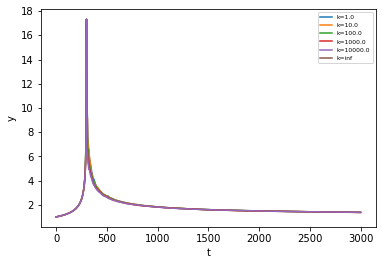

In [156]:


import sys
import os






output_folder_name = '../my_outputs'
output_name = 'dims-30.0-300.0-30.0-gamma-0.1-radius-1.0-prior_sd-1000000.0-noise_sd-1.0-sim-2-k-inf-t-3000-prior_mu-0.0-thin_thresh-2.0-const_infl-5.0-n-10-time-20220927-165650'
figure_folder_name = f"../figures/figures-{output_name}"


if 'plotting' in sys.modules:  
    del sys.modules["plotting"]

from plotting import * 
plot_statistics(output_folder_name, output_name, figure_folder_name, mode = 'd',gamma=0.001)



In [65]:
import cvxpy as cp
import numpy as np

# Generate a random SDP.
n = 2
p = 2
np.random.seed(1)


XX = np.array( [[233.3034206, 178.64461062],
[178.64461062, 245.24271018]] )

lambda_XX = np.linalg.svd(XX)[1]
lambda_XX_inv = 1/lambda_XX

center = np.array([10.47371708, 11.63760344])
XX_inv = np.linalg.inv(XX)



# Define and solve the CVXPY problem.

x = cp.Variable(n)

# The operator >> denotes matrix inequality.


constraints = [x>=0, cp.norm(x,1) <= 1, x@lambda_XX <=  66,  x@lambda_XX  >= 64]

prob = cp.Problem(cp.Maximize( x@lambda_XX_inv ), constraints)

prob.solve()

# Print result.
print("The optimal value is", prob.value)
print("A solution x is")
print(x.value)
print(np.linalg.norm(x.value,1))

The optimal value is 0.01638388442586472
A solution x is
[0.00971013 0.99028987]
0.9999999980806664


In [74]:
lambda_XX = np.linalg.svd(XX)[1]


In [75]:
lambda_XX


array([418.01738995,  60.52874083])

In [83]:
def solve_LP (XX_scale, XX_norm_lower, XX_norm_upper):
    n = XX_scale.shape[0]
    x = cp.Variable(n)
    XX_scale_inv = 1/XX_scale

# The operator >> denotes matrix inequality.


    constraints = [x>=0, cp.norm(x,1) <= 1, x@XX_scale <=  XX_norm_upper,  x@XX_scale  >= XX_norm_lower]

    prob = cp.Problem(cp.Maximize( x@XX_scale_inv ), constraints)

    prob.solve()

    return prob.value, x.value

In [84]:
a, b = solve_LP(lambda_XX,64,66)

In [85]:
solve_LP(np.array([11.47248336,  6.20570517,  4.90206895]), 62,136)

(-inf, None)

In [ ]:
import cvxpy as cp
import numpy as np

# Generate a random SDP.
n = 2
p = 2
np.random.seed(1)


XX = np.array( [[233.3034206, 178.64461062],
[178.64461062, 245.24271018]] )

XX = np.array( [[2, 1],
[1, 1]] )


center = np.array([10.47371708, 11.63760344])
XX_inv = np.linalg.inv(XX)



# Define and solve the CVXPY problem.

x = cp.Variable(n)

# The operator >> denotes matrix inequality.


constraints = [cp.norm(x) <= 1,cp.quad_form(x,XX) <=  66, cp.quad_form(x,XX) >= 64]

prob = cp.Problem(cp.Minimize(cp.quad_form(x,XX_inv)), constraints)

prob.solve()

# Print result.
print("The optimal value is", prob.value)
print("A solution X is")
print(x.value)

TypeError: 'tuple' object is not callable

In [153]:
os.getcwd()


'/Users/yuweiluo/Documents/GitHub/linear-ts/src'

[1.e+00 1.e+01 1.e+02 1.e+03 1.e+04    inf]
index: 1.0,  x: [ 5 10 15 20], y: [0.04403302 0.04959744 0.04423491 0.0496543 ], se: [0.00504453 0.00343725 0.00307925 0.0020851 ]
index: 10.0,  x: [ 5 10 15 20], y: [0.05709267 0.04752142 0.04519571 0.04717575], se: [0.00755726 0.00183976 0.00355216 0.00140997]
index: 100.0,  x: [ 5 10 15 20], y: [0.06721027 0.05242961 0.05336105 0.05367604], se: [0.00478778 0.00355608 0.00271913 0.0030213 ]
index: 1000.0,  x: [ 5 10 15 20], y: [0.05852384 0.04761103 0.04705234 0.05210209], se: [0.0053944  0.00261162 0.00263777 0.00171717]
index: 10000.0,  x: [ 5 10 15 20], y: [0.05528237 0.05143523 0.04903676 0.04405462], se: [0.00498102 0.00311911 0.0021898  0.00315493]
index: inf,  x: [ 5 10 15 20], y: [0.1077405  0.14550715 0.13106493 0.14437892], se: [0.01722611 0.01044628 0.01651574 0.01272879]
[1.e+00 1.e+01 1.e+02 1.e+03 1.e+04    inf]
index: 1.0,  x: [ 5 10 15 20], y: [0. 0. 0. 0.], se: [0. 0. 0. 0.]
index: 10.0,  x: [ 5 10 15 20], y: [1.1906028  0.

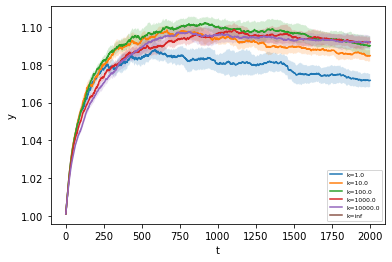

In [154]:

import sys
import os






output_folder_name = '../my_outputs'
output_name = 'dims-5.0-20.0-5.0-gamma-0.01-radius-1.0-prior_sd-2.0-noise_sd-1.0-sim-3-k-inf-t-2000-prior_mu-0.0-thin_thresh-2.0-const_infl-5.0-n-10-time-20220930-032642'
figure_folder_name = f"../figures/figures-{output_name}"


if 'plotting' in sys.modules:  
    del sys.modules["plotting"]

from plotting import * 
plot_statistics(output_folder_name, output_name, figure_folder_name, mode = 'd')

